In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
import warnings

In [ ]:
pip install fastf1

In [ ]:
import fastf1 as ff1
import fastf1.plotting
import fastf1.utils

In [ ]:
# --- 0. 캐시 및 경고 설정 ---
ff1.Cache.enable_cache('/content/f1_dataproject')
warnings.simplefilter(action='ignore', category=FutureWarning)

# --- 1. 세션 로드 (2025 브라질 Q) ---
session = ff1.get_session(2025, 'Brazil', 'Q')

# -----------------------------------------------------------------
# 👇👇👇 [핵심] 이 부분이 telemetry=True 여야 합니다.
# -----------------------------------------------------------------
session.load(telemetry=True)
# -----------------------------------------------------------------

# --- 2. 랩 데이터 로드 ---
bestlap_24 = session.laps.pick_driver('NOR').pick_fastest()
bestlap_25 = session.laps.pick_driver('PIA').pick_fastest()

# 텔레메트리 로드
tel_24 = bestlap_24.get_telemetry()
tel_25 = bestlap_25.get_telemetry()

print(f"Loaded NOR (bestlap_24): {bestlap_24.LapTime}")
print(f"Loaded PIA (bestlap_25): {bestlap_25.LapTime}")

core           INFO 	Loading data for São Paulo Grand Prix - Qualifying [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for São Paulo Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core           INFO 	Processing timing data...
INFO:fastf1.fastf1.core:Processing timing data...
core    

Loaded NOR (bestlap_24): 0 days 00:01:09.511000
Loaded PIA (bestlap_25): 0 days 00:01:09.835000


--- 1. 종합 대시보드 그리는 중... ---
Sector 1/2/3 구분선 로드 완료: 1219m, 3115m
Full styled telemetry comparison graph saved as 'nor_vs_pia_telemetry_dashboard.png'


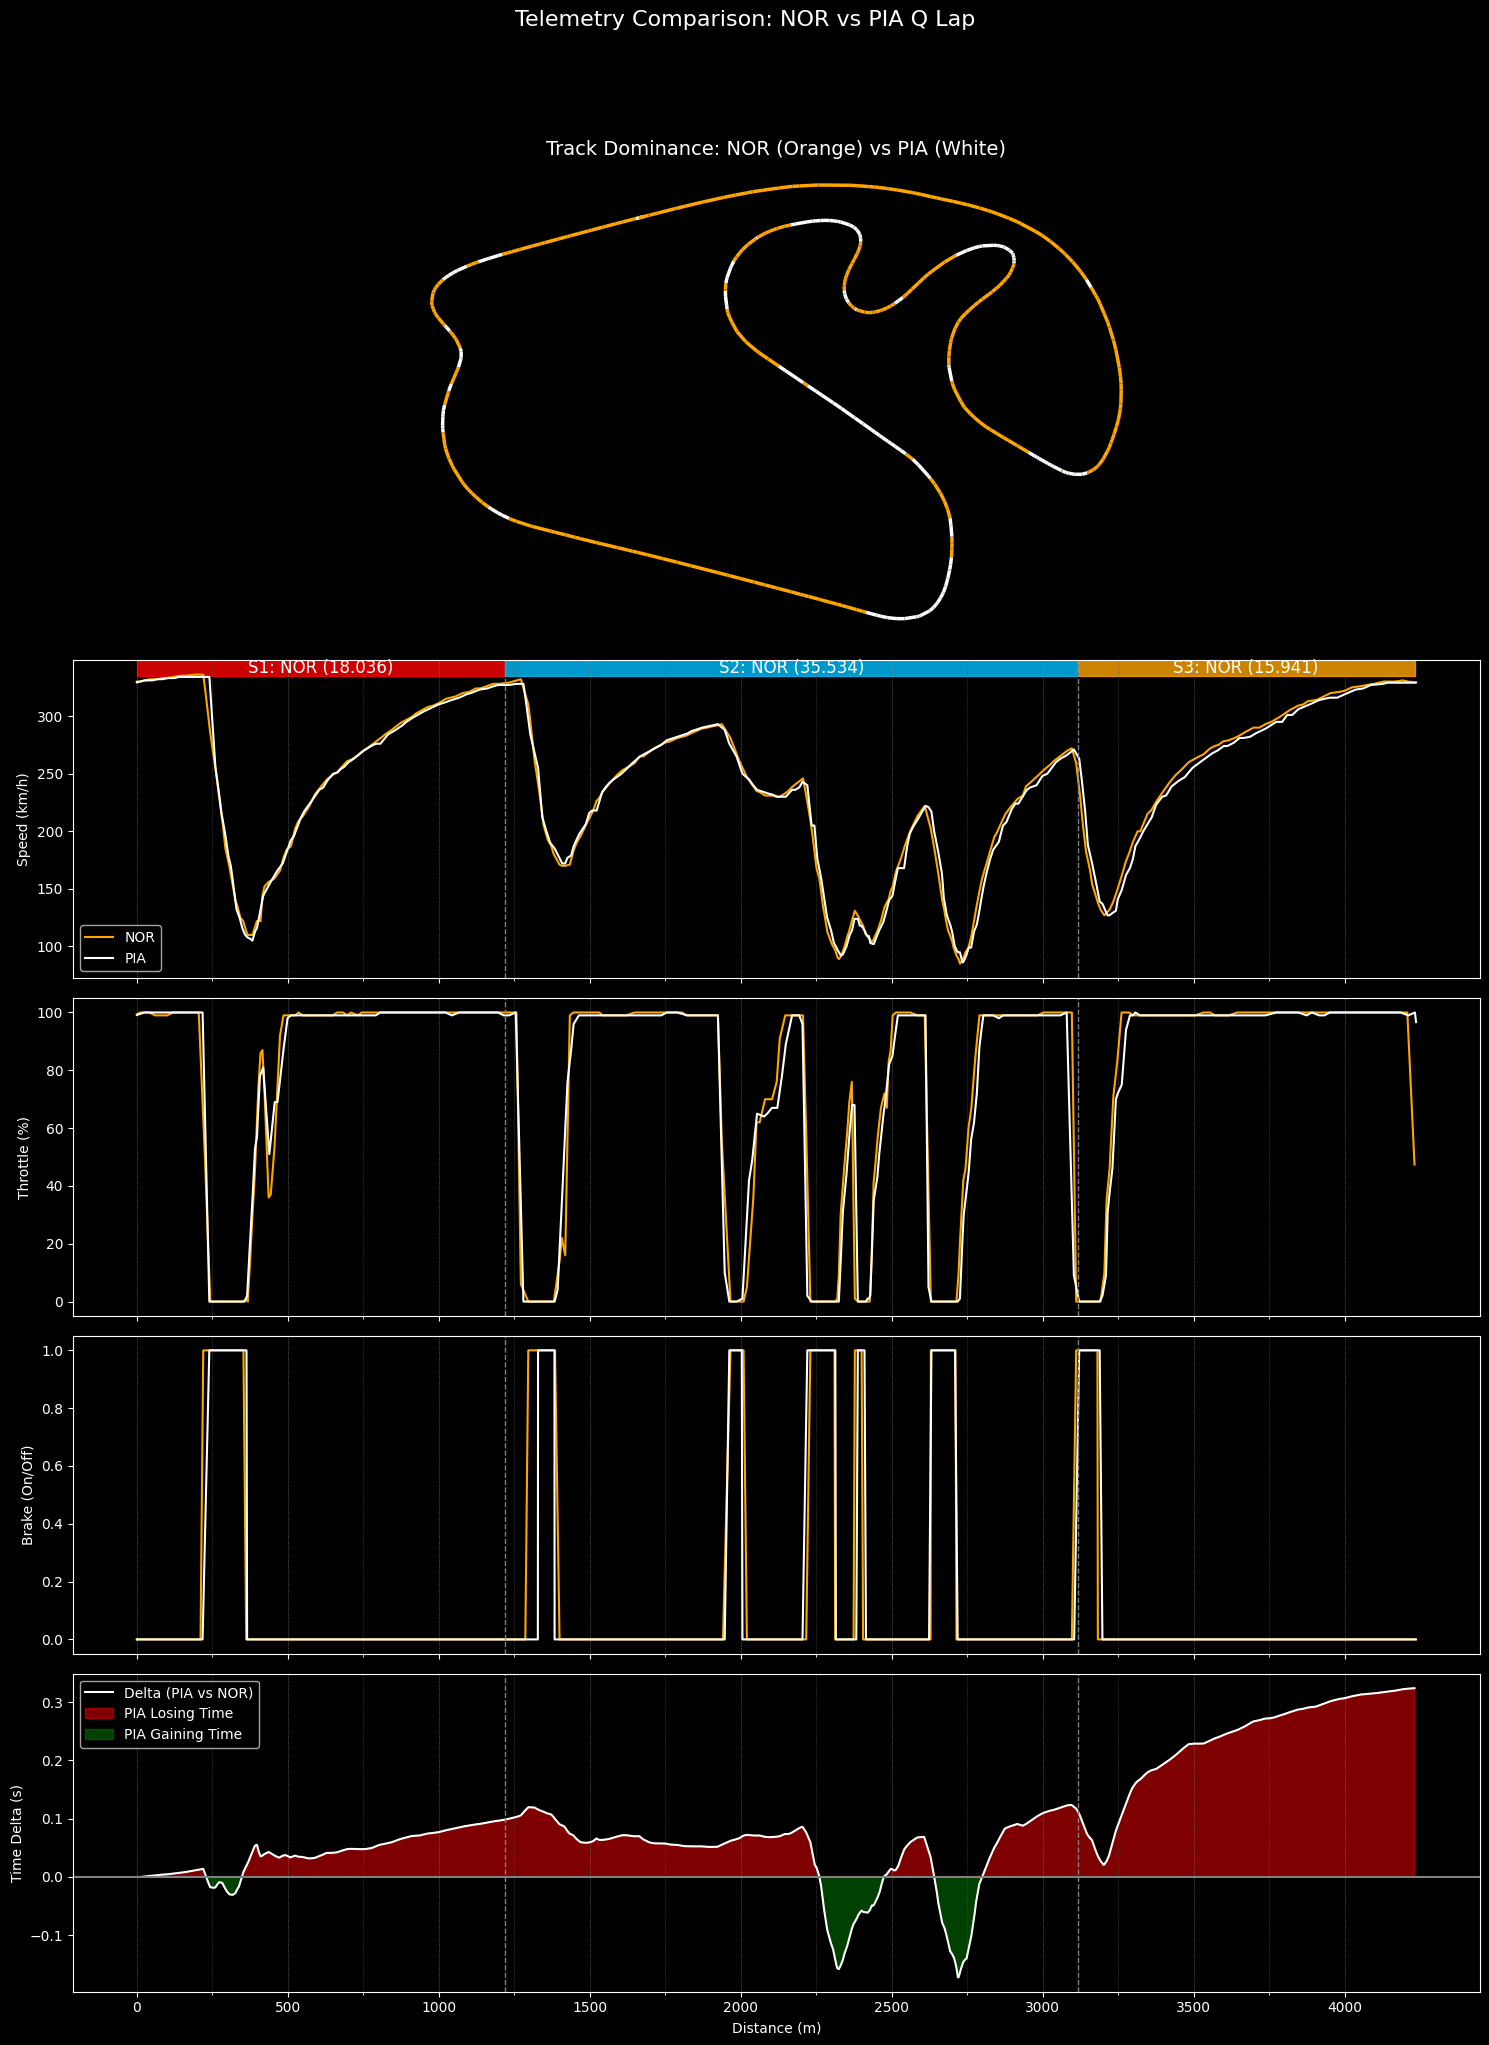


--- 📊 Bar Chart Data Calculated ---


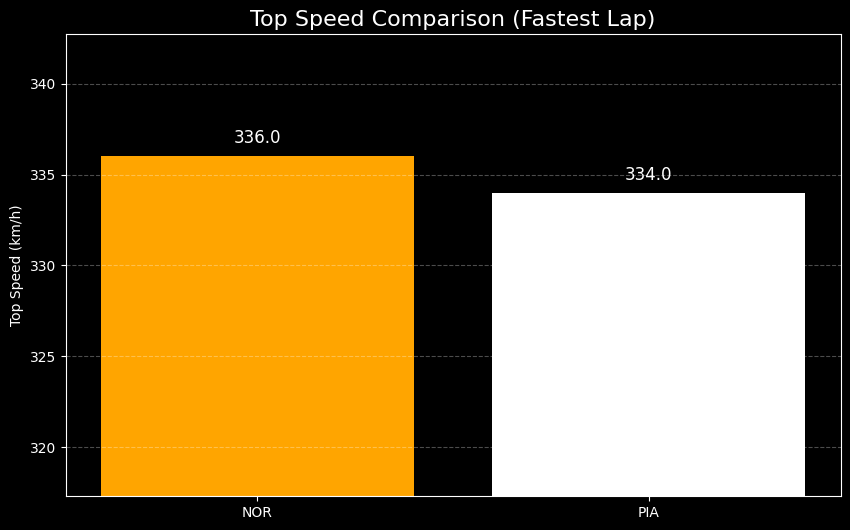

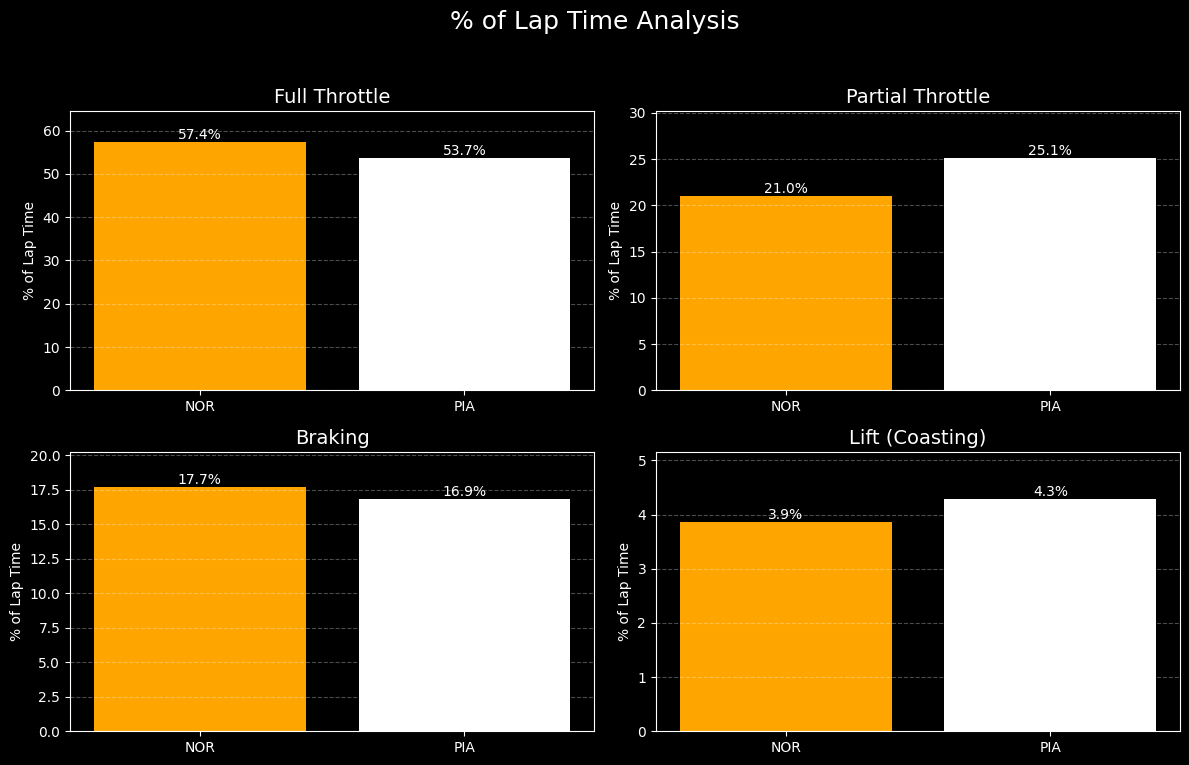


--- ⚡ 4. DRS 효과 분석 (최고 속도 기준) ---
[NOR] DRS On: 336.0 km/h | DRS Off: 310.0 km/h | Delta: +26.0 km/h
[PIA] DRS On: 334.0 km/h | DRS Off: 294.3 km/h | Delta: +39.7 km/h


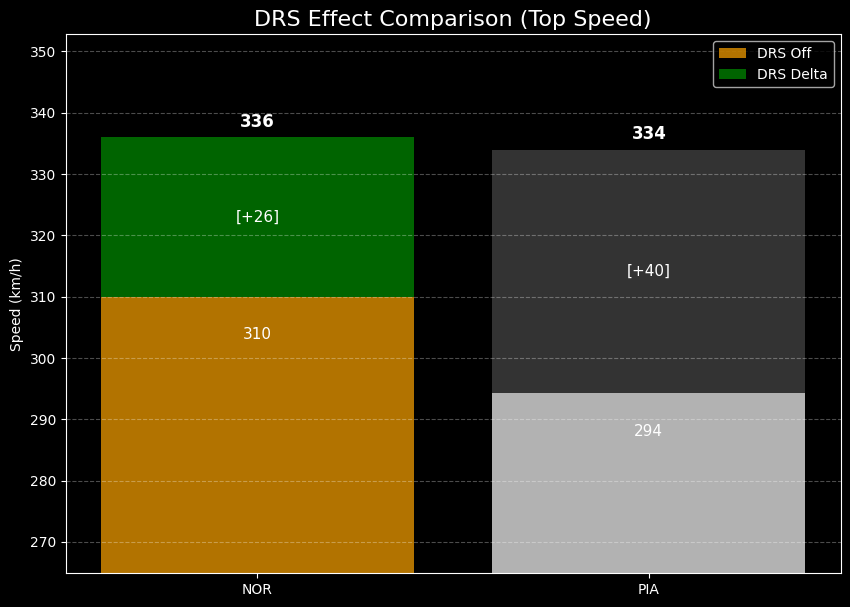

In [ ]:
# --- 0. 스타일 설정 (맨 위에 한 번만!) ---
# 이 함수가 다크 모드 배경과 그리드 스타일을 모두 설정합니다.
plt.style.use(['dark_background'])
fastf1.plotting.setup_mpl(mpl_timedelta_support=True, color_scheme=None, misc_mpl_mods=True)
warnings.simplefilter(action='ignore', category=FutureWarning)

# --- 1. 헬퍼 함수 정의 (막대 그래프용) ---
# [수정] find_sector_distances 함수 제거됨

def analyze_lap_sections(lap, telemetry):
    if 'Time' not in telemetry.columns:
        telemetry = lap.get_telemetry()
    time_deltas = telemetry['Time'].diff().dt.total_seconds().fillna(0)
    total_time = lap.LapTime.total_seconds()
    full_throttle_time = time_deltas[telemetry['Throttle'] >= 99].sum()
    braking_time = time_deltas[telemetry['Brake'] > 0.05].sum()
    lift_time = time_deltas[(telemetry['Throttle'] < 5) & (telemetry['Brake'] < 0.05)].sum()
    partial_time = total_time - full_throttle_time - braking_time - lift_time
    return {
        'Full Throttle': (full_throttle_time / total_time) * 100,
        'Partial Throttle': (partial_time / total_time) * 100,
        'Braking': (braking_time / total_time) * 100,
        'Lift (Coasting)': (lift_time / total_time) * 100
    }

def analyze_drs_effect(telemetry):
    if 'DRS' not in telemetry.columns:
        telemetry = lap.get_telemetry()
        if 'DRS' not in telemetry.columns:
             return {'DRS On Speed': 0, 'DRS Off Speed': 0, 'DRS Delta': 0}
    speed_drs_on = telemetry[telemetry['DRS'] >= 10]['Speed'].max()
    speed_drs_off = telemetry[telemetry['DRS'] < 10]['Speed'].max()
    if pd.isna(speed_drs_on) or pd.isna(speed_drs_off) or speed_drs_on == -np.inf or speed_drs_off == -np.inf:
        return {'DRS On Speed': 0, 'DRS Off Speed': 0, 'DRS Delta': 0}
    return {'DRS On Speed': speed_drs_on, 'DRS Off Speed': speed_drs_off, 'DRS Delta': speed_drs_on - speed_drs_off}

# --- 2. [그래프 1: 종합 대시보드] ---
try:
    print("--- 1. 종합 대시보드 그리는 중... ---")
    tel_24 = bestlap_24.get_telemetry().add_distance()
    tel_25 = bestlap_25.get_telemetry().add_distance()
    delta_t, ref_tel, comp_tel = ff1.utils.delta_time(bestlap_24, bestlap_25)
    ref_distance = ref_tel['Distance']
    orig_distance = tel_24['Distance']
    delta_t_interpolated = np.interp(orig_distance, ref_distance, delta_t)

    color_24 = 'orange' # norris
    color_25 = 'white'         # piastri

    fig = plt.figure(figsize=(15, 20))
    gs = fig.add_gridspec(5, 1, height_ratios=[1.5, 1, 1, 1, 1])
    ax_map = fig.add_subplot(gs[0])
    ax_speed = fig.add_subplot(gs[1])
    ax_throttle = fig.add_subplot(gs[2], sharex=ax_speed)
    ax_brake = fig.add_subplot(gs[3], sharex=ax_speed)
    ax_delta = fig.add_subplot(gs[4], sharex=ax_speed)

    # 7. 트랙 맵 시각화 (Track Dominance) - 90도 오른쪽 회전
    ax_map.set_title(f"Track Dominance: NOR (Orange) vs PIA (White)", fontsize=14)
    d_delta = np.diff(delta_t_interpolated)
    colors = [color_25 if d < 0 else color_24 for d in d_delta]
    x_rotated = tel_24['Y'].values
    y_rotated = -tel_24['X'].values
    points = np.array([x_rotated, y_rotated]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, colors=colors, linewidth=2.5)
    ax_map.add_collection(lc)
    ax_map.axis('equal'); ax_map.set_xticks([]); ax_map.set_yticks([]); ax_map.axis('off')

    # 8. 텔레메트리 스타일링

    # -----------------------------------------------------
    # 👇👇👇 [핵심 수정] 랩 객체의 'SectorxTime'을 사용해 거리 계산
    # -----------------------------------------------------
    track_end_dist = tel_24['Distance'].max()
    try:
        # S1/S2가 끝나는 '시간' (초)
        s1_time_seconds = bestlap_24.Sector1Time.total_seconds()
        s2_time_seconds = bestlap_24.Sector2Time.total_seconds() + s1_time_seconds # S2 종료 시간 = S1 + S2

        # 텔레메트리의 시간(초) 및 거리 데이터
        tel_time_seconds = tel_24['Time'].dt.total_seconds()
        tel_distance = tel_24['Distance']

        # np.interp를 사용해 해당 시간에 해당하는 거리를 보간하여 찾음
        s1_dist = np.interp(s1_time_seconds, tel_time_seconds, tel_distance)
        s2_dist = np.interp(s2_time_seconds, tel_time_seconds, tel_distance)

        if pd.isna(s1_dist) or pd.isna(s2_dist):
             raise ValueError("Sector distance calculation returned NaN.")
        print(f"Sector 1/2/3 구분선 로드 완료: {s1_dist:.0f}m, {s2_dist:.0f}m")
    except Exception as e:
        s1_dist, s2_dist = None, None
        print(f"--- ⚠️ Warning: 섹터 구분선 로드 실패. ({e}) ---")
    # -----------------------------------------------------

    fig.suptitle(f"Telemetry Comparison: {bestlap_24.Driver} vs {bestlap_25.Driver} Q Lap", fontsize=16, y=1.02)

    ax_speed.plot(tel_24['Distance'], tel_24['Speed'], label='NOR', color=color_24)
    ax_speed.plot(tel_25['Distance'], tel_25['Speed'], label='PIA', color=color_25)
    ax_speed.set_ylabel('Speed (km/h)'); ax_speed.legend()
    plt.setp(ax_speed.get_xticklabels(), visible=False)

    ax_throttle.plot(tel_24['Distance'], tel_24['Throttle'], label='NOR', color=color_24)
    ax_throttle.plot(tel_25['Distance'], tel_25['Throttle'], label='PIA', color=color_25)
    ax_throttle.set_ylabel('Throttle (%)')
    plt.setp(ax_throttle.get_xticklabels(), visible=False)

    ax_brake.plot(tel_24['Distance'], tel_24['Brake'].astype(int), label='NOR', color=color_24)
    ax_brake.plot(tel_25['Distance'], tel_25['Brake'].astype(int), label='PIA', color=color_25)
    ax_brake.set_ylabel('Brake (On/Off)')
    plt.setp(ax_brake.get_xticklabels(), visible=False)

    ax_delta.plot(tel_24['Distance'], delta_t_interpolated, color='white', label='Delta (PIA vs NOR)')
    ax_delta.axhline(0, color='grey', linestyle='-')
    ax_delta.set_ylabel('Time Delta (s)'); ax_delta.set_xlabel('Distance (m)')
    ax_delta.fill_between(tel_24['Distance'], delta_t_interpolated, 0, where=delta_t_interpolated > 0, color='red', alpha=0.5, interpolate=True, label='PIA Losing Time')
    ax_delta.fill_between(tel_24['Distance'], delta_t_interpolated, 0, where=delta_t_interpolated < 0, color='green', alpha=0.5, interpolate=True, label='PIA Gaining Time')
    ax_delta.legend()

    # 9. 그리드, 섹터 구분선, X축 틱 설정
    major_ticks = np.arange(0, track_end_dist, 500)
    minor_ticks = np.arange(0, track_end_dist, 250)
    for ax in [ax_speed, ax_throttle, ax_brake, ax_delta]:
        ax.set_xticks(major_ticks); ax.set_xticks(minor_ticks, minor=True)
        ax.grid(which='major', axis='x', linestyle=':', linewidth=0.5, color='#888888')
        ax.grid(which='minor', axis='x', linestyle=':', linewidth=0.5, color='#555555')

        if s1_dist and s2_dist:
            ax.axvline(s1_dist, color='grey', linestyle='--', linewidth=1.0)
            ax.axvline(s2_dist, color='grey', linestyle='--', linewidth=1.0)

    # 섹터 배경색 및 S1, S2, S3 텍스트
    if s1_dist and s2_dist:
        s1_nor_time = bestlap_24.Sector1Time.total_seconds()
        s1_pia_time = bestlap_25.Sector1Time.total_seconds()
        s1_leader = "NOR" if s1_nor_time <= s1_pia_time else "PIA"
        s1_time = min(s1_nor_time, s1_pia_time)
        s1_color = 'red'
        s1_label = f"S1: {s1_leader} ({s1_time:.3f})"

        s2_nor_time = bestlap_24.Sector2Time.total_seconds()
        s2_pia_time = bestlap_25.Sector2Time.total_seconds()
        s2_leader = "NOR" if s2_nor_time <= s2_pia_time else "PIA"
        s2_time = min(s2_nor_time, s2_pia_time)
        s2_color = 'deepskyblue'
        s2_label = f"S2: {s2_leader} ({s2_time:.3f})"

        s3_nor_time = bestlap_24.Sector3Time.total_seconds()
        s3_pia_time = bestlap_25.Sector3Time.total_seconds()
        s3_leader = "NOR" if s3_nor_time <= s3_pia_time else "PIA"
        s3_time = min(s3_nor_time, s3_pia_time)
        s3_color = 'orange'
        s3_label = f"S3: {s3_leader} ({s3_time:.3f})"

        y_min, y_max = ax_speed.get_ylim()
        bar_height_ratio = 0.05
        bar_y_pos = 1 - bar_height_ratio
        text_y_pos = y_max - (y_max - y_min) * (bar_height_ratio / 2)

        ax_speed.axvspan(0, s1_dist, ymin=bar_y_pos, ymax=1, color=s1_color, alpha=0.8)
        ax_speed.axvspan(s1_dist, s2_dist, ymin=bar_y_pos, ymax=1, color=s2_color, alpha=0.8)
        ax_speed.axvspan(s2_dist, track_end_dist, ymin=bar_y_pos, ymax=1, color=s3_color, alpha=0.8)

        text_color_s1 = 'white'
        text_color_s2 = 'white'
        text_color_s3 = 'white'

        ax_speed.text(s1_dist/2, text_y_pos, s1_label, ha='center', va='center', fontsize=12, color=text_color_s1)
        ax_speed.text((s1_dist+s2_dist)/2, text_y_pos, s2_label, ha='center', va='center', fontsize=12, color=text_color_s2)
        ax_speed.text((s2_dist+track_end_dist)/2, text_y_pos, s3_label, ha='center', va='center', fontsize=12, color=text_color_s3)
    else:
        print("--- ⚠️ Warning: 섹터 컬러 바를 그릴 수 없습니다 (s1_dist/s2_dist가 None). ---")

    # 10. 그래프 저장 및 출력
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig('nor_vs_pia_telemetry_dashboard.png', dpi=300)
    print("Full styled telemetry comparison graph saved as 'nor_vs_pia_telemetry_dashboard.png'")
    plt.show()

except Exception as e:
    print(f"An unexpected error occurred during Dashboard plotting: {e}")

# --- 3. [그래프 2, 3, 4: 막대 그래프] ---
# (막대 그래프에 필요한 데이터 계산)
try:
    max_speed_24 = tel_24['Speed'].max()
    max_speed_25 = tel_25['Speed'].max()
    sections_24 = analyze_lap_sections(bestlap_24, tel_24)
    sections_25 = analyze_lap_sections(bestlap_25, tel_25)
    df_sections = pd.DataFrame({'NOR': sections_24, 'PIA': sections_25})
    drs_24_data = analyze_drs_effect(tel_24)
    drs_25_data = analyze_drs_effect(tel_25)
    print("\n--- 📊 Bar Chart Data Calculated ---")
except Exception as e:
    print(f"An unexpected error occurred during bar chart data calculation: {e}")


# --- [그래프 2: 최고 속도 비교] ---
try:
    drivers = ['NOR', 'PIA']
    speeds = [max_speed_24, max_speed_25]
    colors = [color_24, color_25]

    # [수정] plt.style.use('dark_background') 제거
    fig_speed, ax_speed_bar = plt.subplots(figsize=(10, 6))
    bars = ax_speed_bar.bar(drivers, speeds, color=colors)
    ax_speed_bar.set_title('Top Speed Comparison (Fastest Lap)', fontsize=16)
    ax_speed_bar.set_ylabel('Top Speed (km/h)')
    ax_speed_bar.set_ylim(min(speeds)*0.95, max(speeds)*1.02) # y_lim 수정

    for bar in bars:
        height = bar.get_height()
        ax_speed_bar.text(bar.get_x() + bar.get_width()/2.0, height + 0.5,
                f'{height:.1f}', ha='center', va='bottom', fontsize=12)

    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.savefig('compare_top_speed.png', dpi=150, bbox_inches='tight')
    plt.show()
except Exception as e:
    print(f"--- ⚠️ Top Speed Plot 오류 --- {e}")

# --- [그래프 3: 주행 스타일 분석] ---
try:
    categories = ['Full Throttle', 'Partial Throttle', 'Braking', 'Lift (Coasting)']
    data_24 = df_sections['NOR']
    data_25 = df_sections['PIA']

    # [수정] plt.style.use('dark_background') 제거
    fig_sections, axes_sections = plt.subplots(2, 2, figsize=(12, 8))
    fig_sections.suptitle('% of Lap Time Analysis', fontsize=18)

    for i, (ax, category) in enumerate(zip(axes_sections.flat, categories)):
        bars = ax.bar(['NOR', 'PIA'], [data_24[category], data_25[category]], color=[color_24, color_25])
        ax.set_title(category, fontsize=14); ax.set_ylabel('% of Lap Time')

        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2.0, height,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

        if height > 0: ax.set_ylim(top=height * 1.2)
        ax.grid(axis='y', linestyle='--', alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('compare_lap_sections.png', dpi=150, bbox_inches='tight')
    plt.show()
except Exception as e:
    print(f"--- ⚠️ Lap Sections Plot 오류 --- {e}")

# --- [그래프 4: DRS 효과 분석] ---
try:
    print(f"\n--- ⚡ 4. DRS 효과 분석 (최고 속도 기준) ---") # 텍스트 출력 추가
    print(f"[NOR] DRS On: {drs_24_data['DRS On Speed']:.1f} km/h | DRS Off: {drs_24_data['DRS Off Speed']:.1f} km/h | Delta: +{drs_24_data['DRS Delta']:.1f} km/h")
    print(f"[PIA] DRS On: {drs_25_data['DRS On Speed']:.1f} km/h | DRS Off: {drs_25_data['DRS Off Speed']:.1f} km/h | Delta: +{drs_25_data['DRS Delta']:.1f} km/h")

    categories = ['NOR', 'PIA']
    drs_off_speeds = [drs_24_data['DRS Off Speed'], drs_25_data['DRS Off Speed']]
    drs_deltas = [drs_24_data['DRS Delta'], drs_25_data['DRS Delta']]
    drs_on_speeds = [drs_24_data['DRS On Speed'], drs_25_data['DRS On Speed']]
    colors_bottom = [color_24, color_25]; colors_top = ['darkgreen', '#333333']

    # [수정] plt.style.use('dark_background') 제거
    fig_drs, ax_drs = plt.subplots(figsize=(10, 7))

    ax_drs.bar(categories, drs_off_speeds, label='DRS Off', color=colors_bottom, alpha=0.7)
    ax_drs.bar(categories, drs_deltas, bottom=drs_off_speeds, label='DRS Delta', color=colors_top)

    ax_drs.set_title('DRS Effect Comparison (Top Speed)', fontsize=16)
    ax_drs.set_ylabel('Speed (km/h)'); ax_drs.set_ylim(min(drs_off_speeds)*0.9, max(drs_on_speeds)*1.05); ax_drs.legend()

    for i, cat in enumerate(categories):
        on_speed = drs_on_speeds[i]; off_speed = drs_off_speeds[i]; delta = drs_deltas[i]

        # [수정] 텍스트 색상 동적 변경
        bottom_text_color = 'black' if colors_bottom[i] == 'lawngreen' else 'white'
        top_text_color = 'white'

        ax_drs.text(cat, on_speed + 1, f"{on_speed:.0f}", ha='center', va='bottom', fontsize=12, weight='bold')
        ax_drs.text(cat, off_speed + (delta / 2), f"[+{delta:.0f}]", ha='center', va='center', fontsize=11, color=top_text_color)
        # [수정] Y위치 및 정렬 변경
        ax_drs.text(cat, off_speed - 5, f"{off_speed:.0f}", ha='center', va='top', fontsize=11, color=bottom_text_color)

    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.savefig('compare_drs_delta.png', dpi=150, bbox_inches='tight')
    plt.show()

except Exception as e:
     print(f"--- ⚠️ DRS Delta 분석/플롯 오류 --- {e}")

In [ ]:
try:
    # 1. 헬퍼 함수 (이미 메모리에 있어야 함)
    # def analyze_lap_sections(lap, telemetry): ...
    # def analyze_drs_effect(telemetry): ...

    # 2. 서킷 정보 로드
    circuit_info = session_24.get_circuit_info()

    # 3. 종합 랩 타임 및 섹터 데이터 추출
    kpi_data = {
        "driver": bestlap_24.Driver,
        "event": session_24.event['EventName'],
        "lap_time_24": str(bestlap_24.LapTime),  # API 전송을 위해 문자열로 변환
        "lap_time_25": str(bestlap_25.LapTime),
        "lap_time_diff": str(bestlap_25.LapTime - bestlap_24.LapTime),

        "sector1_diff": str(bestlap_25.Sector1Time - bestlap_24.Sector1Time),
        "sector2_diff": str(bestlap_25.Sector2Time - bestlap_24.Sector2Time),
        "sector3_diff": str(bestlap_25.Sector3Time - bestlap_24.Sector3Time),
    }

    # 4. 텔레메트리 기반 KPI 추출

    # (KPI 1: 메인 스트레이트 최고 속도 및 브레이킹 포인트)
    try:
        braking_index_24 = (tel_24['Brake'] > 0).idxmax()
        braking_index_25 = (tel_25['Brake'] > 0).idxmax()
        main_straight_tel_24 = tel_24.loc[:braking_index_24]
        main_straight_tel_25 = tel_25.loc[:braking_index_25]

        kpi_data["max_speed_straight_24"] = main_straight_tel_24['Speed'].max()
        kpi_data["max_speed_straight_25"] = main_straight_tel_25['Speed'].max()
        kpi_data["braking_point_distance_24"] = main_straight_tel_24.iloc[-1]['Distance']
        kpi_data["braking_point_distance_25"] = main_straight_tel_25.iloc[-1]['Distance']

    except Exception:
        kpi_data["max_speed_straight_24"] = tel_24['Speed'].max()
        kpi_data["max_speed_straight_25"] = tel_25['Speed'].max()
        kpi_data["braking_point_distance_24"] = "N/A"
        kpi_data["braking_point_distance_25"] = "N/A"

    # (KPI 2: T1 코너 최저 속도)
    try:
        t1_info = circuit_info.corners['1'] # 코너 '1' (문자열)
        t1_distance = t1_info['Distance']
        t1_range_24 = (tel_24['Distance'] > t1_distance - 50) & (tel_24['Distance'] < t1_distance + 50)
        t1_slice_24 = tel_24[t1_range_24 & (tel_24['Speed'] > 0)]['Speed']
        kpi_data["min_speed_T1_24"] = 0.0 if t1_slice_24.empty else t1_slice_24.min()

        t1_range_25 = (tel_25['Distance'] > t1_distance - 50) & (tel_25['Distance'] < t1_distance + 50)
        t1_slice_25 = tel_25[t1_range_25 & (tel_25['Speed'] > 0)]['Speed']
        kpi_data["min_speed_T1_25"] = 0.0 if t1_slice_25.empty else t1_slice_25.min()
    except Exception:
        kpi_data["min_speed_T1_24"] = 0.0
        kpi_data["min_speed_T1_25"] = 0.0

    # (KPI 3: 주행 스타일 분석) - [통합]
    sections_24 = analyze_lap_sections(bestlap_24, tel_24)
    sections_25 = analyze_lap_sections(bestlap_25, tel_25)
    df_sections = pd.DataFrame({'NOR': sections_24, 'PIA': sections_25})
    df_sections['Delta (NOR-PIA)'] = df_sections['PIA'] - df_sections['NOR']
    kpi_data["df_sections_string"] = df_sections.to_string(float_format='%.1f%%') # API 전송용 문자열

    # (KPI 4: DRS 효과 분석) - [통합]
    drs_24_data = analyze_drs_effect(tel_24)
    drs_25_data = analyze_drs_effect(tel_25)
    kpi_data["drs_24_string"] = f"DRS On: {drs_24_data['DRS On Speed']:.1f} km/h | DRS Off: {drs_24_data['DRS Off Speed']:.1f} km/h | Delta: +{drs_24_data['DRS Delta']:.1f} km/h"
    kpi_data["drs_25_string"] = f"DRS On: {drs_25_data['DRS On Speed']:.1f} km/h | DRS Off: {drs_25_data['DRS Off Speed']:.1f} km/h | Delta: +{drs_25_data['DRS Delta']:.1f} km/h"

    print("\n--- 📊 모든 KPI 데이터가 'kpi_data' 딕셔너리에 통합되었습니다 ---")
    # print(kpi_data) # 전체 데이터 확인용

except Exception as e:
    print(f"An unexpected error occurred during KPI extraction: {e}")


--- 📊 모든 KPI 데이터가 'kpi_data' 딕셔너리에 통합되었습니다 ---


--- 📊 1. 랩 타임 및 섹터 분석 ---
                            NOR                    PIA                    Delta
Lap Time 0 days 00:01:09.511000 0 days 00:01:09.835000 -1 days +23:59:59.676000
Sector 1 0 days 00:00:18.036000 0 days 00:00:18.127000 -1 days +23:59:59.909000
Sector 2 0 days 00:00:35.534000 0 days 00:00:35.596000 -1 days +23:59:59.938000
Sector 3 0 days 00:00:15.941000 0 days 00:00:16.112000 -1 days +23:59:59.829000

[분석 요약]
Sector 1: -0.091s | Sector 2: -0.062s | Sector 3: -0.171s

--- 🚀 2. 최고 속도 비교 (Fastest Lap) ---
NOR Max Speed: 336.0 km/h
PIA Max Speed: 334.0 km/h
[차이]: -2.0 km/h


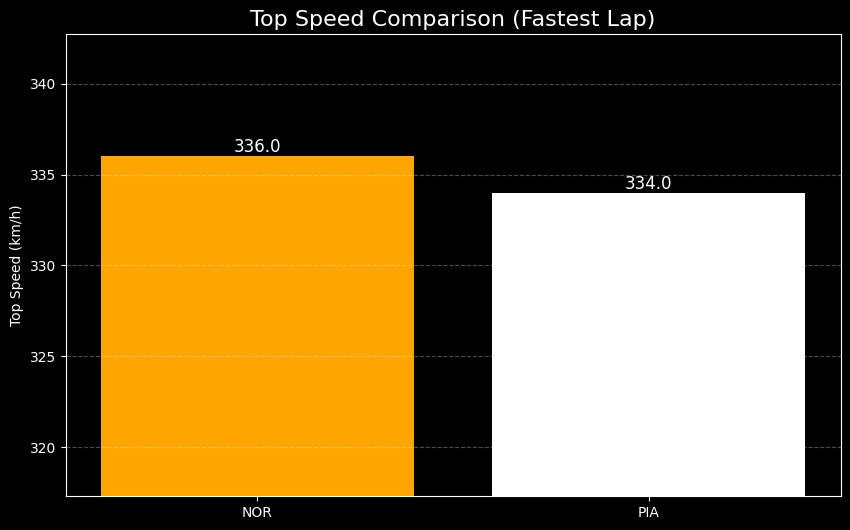


--- 📈 3. 주행 스타일 분석 (% of Lap Time) ---
                   NOR   PIA  Delta (PIA-NOR)
Full Throttle    57.4% 53.7%             3.7%
Partial Throttle 21.0% 25.1%            -4.1%
Braking          17.7% 16.9%             0.9%
Lift (Coasting)   3.9%  4.3%            -0.4%


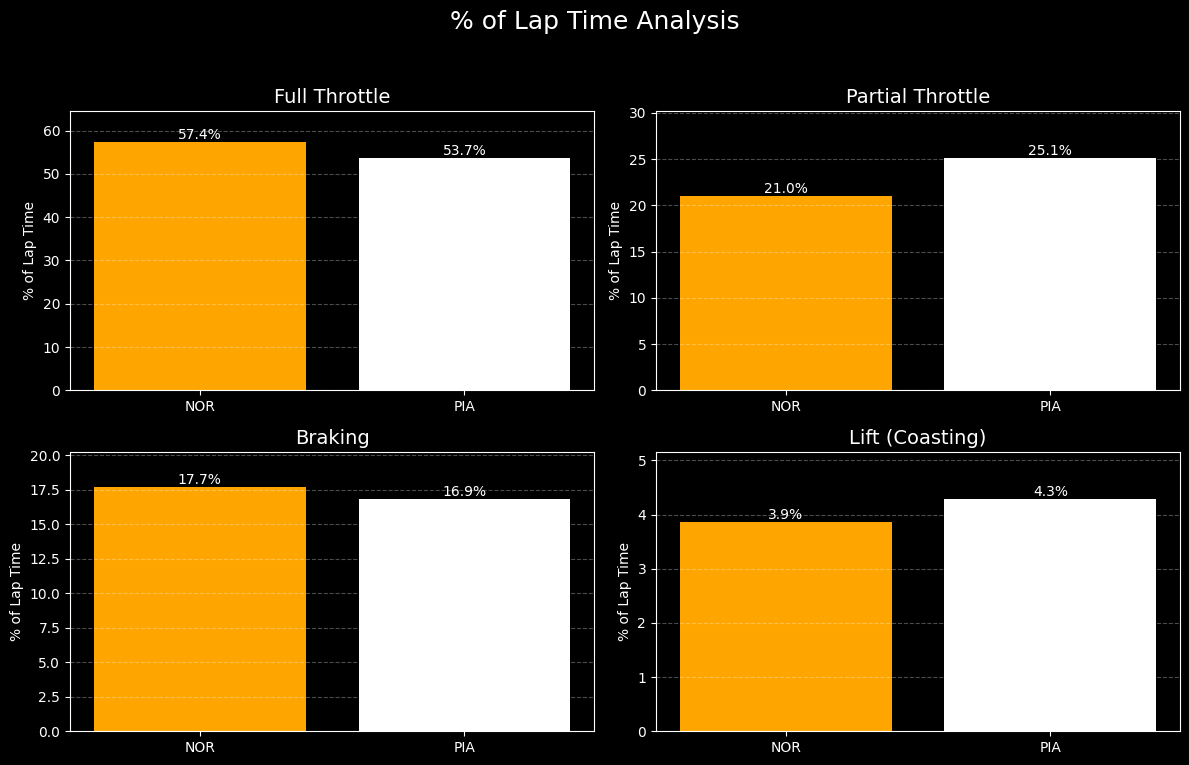


--- ⚡ 4. DRS 효과 분석 (최고 속도 기준) ---
[NOR] DRS On: 336.0 km/h | DRS Off: 310.0 km/h | Delta: +26.0 km/h
[PIA] DRS On: 334.0 km/h | DRS Off: 294.3 km/h | Delta: +39.7 km/h


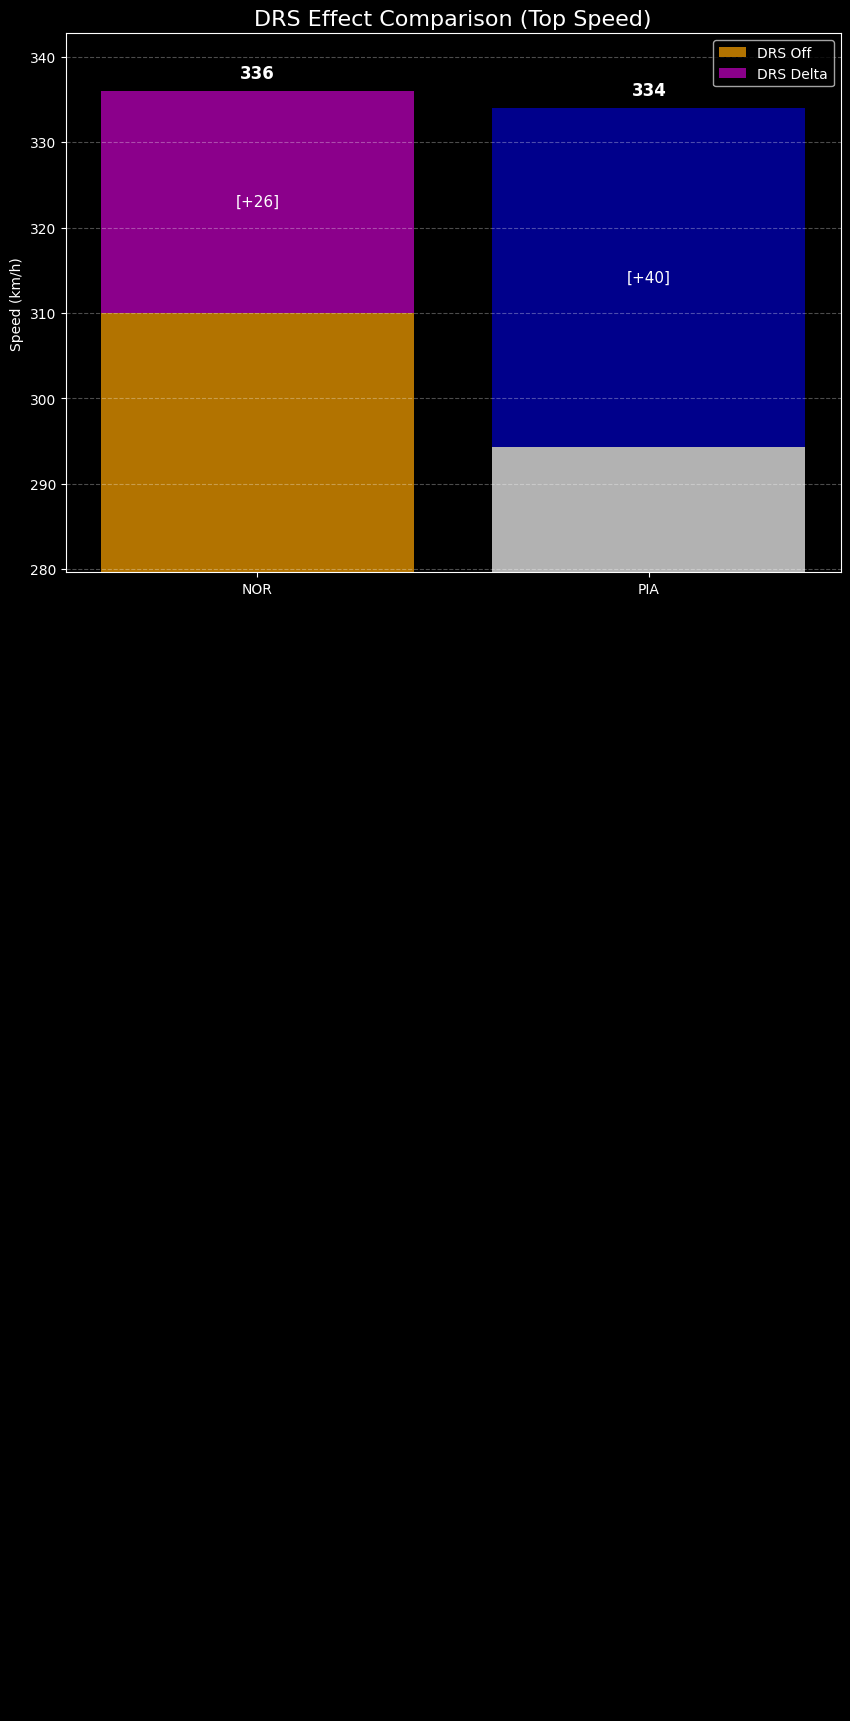

In [ ]:
# --- 0. 헬퍼 함수 정의 ---
# (이 함수들이 [셀 78] 등에 이미 정의되어 있다면 이 부분은 생략해도 됩니다)
def analyze_lap_sections(lap, telemetry):
    if 'Time' not in telemetry.columns:
        telemetry = lap.get_telemetry()
    time_deltas = telemetry['Time'].diff().dt.total_seconds().fillna(0)
    total_time = lap.LapTime.total_seconds()
    full_throttle_time = time_deltas[telemetry['Throttle'] >= 99].sum()
    braking_time = time_deltas[telemetry['Brake'] > 0.05].sum()
    lift_time = time_deltas[(telemetry['Throttle'] < 5) & (telemetry['Brake'] < 0.05)].sum()
    partial_time = total_time - full_throttle_time - braking_time - lift_time
    return {
        'Full Throttle': (full_throttle_time / total_time) * 100,
        'Partial Throttle': (partial_time / total_time) * 100,
        'Braking': (braking_time / total_time) * 100,
        'Lift (Coasting)': (lift_time / total_time) * 100
    }

def analyze_drs_effect(telemetry):
    if 'DRS' not in telemetry.columns:
        telemetry = lap.get_telemetry()
        if 'DRS' not in telemetry.columns:
             return {'DRS On Speed': 0, 'DRS Off Speed': 0, 'DRS Delta': 0}
    speed_drs_on = telemetry[telemetry['DRS'] >= 10]['Speed'].max()
    speed_drs_off = telemetry[telemetry['DRS'] < 10]['Speed'].max()
    if pd.isna(speed_drs_on) or pd.isna(speed_drs_off) or speed_drs_on == -np.inf or speed_drs_off == -np.inf:
        return {'DRS On Speed': 0, 'DRS Off Speed': 0, 'DRS Delta': 0}
    return {'DRS On Speed': speed_drs_on, 'DRS Off Speed': speed_drs_off, 'DRS Delta': speed_drs_on - speed_drs_off}

print("--- 📊 1. 랩 타임 및 섹터 분석 ---")
try:
    data = {
        'NOR': {'Lap Time': bestlap_24.LapTime, 'Sector 1': bestlap_24.Sector1Time, 'Sector 2': bestlap_24.Sector2Time, 'Sector 3': bestlap_24.Sector3Time},
        'PIA': {'Lap Time': bestlap_25.LapTime, 'Sector 1': bestlap_25.Sector1Time, 'Sector 2': bestlap_25.Sector2Time, 'Sector 3': bestlap_25.Sector3Time}
    }
    df_timing = pd.DataFrame(data)
    df_timing['Delta'] = df_timing['NOR'] - df_timing['PIA']
    print(df_timing.to_string(float_format="%.3f"))
    s1_delta = df_timing.loc['Sector 1', 'Delta'].total_seconds()
    s2_delta = df_timing.loc['Sector 2', 'Delta'].total_seconds()
    s3_delta = df_timing.loc['Sector 3', 'Delta'].total_seconds()
    print(f"\n[분석 요약]\nSector 1: {s1_delta:+.3f}s | Sector 2: {s2_delta:+.3f}s | Sector 3: {s3_delta:+.3f}s")
except Exception as e:
    print(f"랩 타임 분석 오류: {e}")

print("\n--- 🚀 2. 최고 속도 비교 (Fastest Lap) ---")
try:
    max_speed_24 = tel_24['Speed'].max()
    max_speed_25 = tel_25['Speed'].max()
    speed_delta = max_speed_25 - max_speed_24
    print(f"NOR Max Speed: {max_speed_24:.1f} km/h")
    print(f"PIA Max Speed: {max_speed_25:.1f} km/h")
    print(f"[차이]: {speed_delta:+.1f} km/h")

    # 그래프 생성 및 저장
    plt.style.use('dark_background')
    fig_speed, ax_speed = plt.subplots(figsize=(10, 6))
    drivers = ['NOR', 'PIA']
    speeds = [max_speed_24, max_speed_25]
    colors = [color_24, color_25] # color_24/25는 [셀 77]에서 정의됨
    bars = ax_speed.bar(drivers, speeds, color=colors)
    ax_speed.set_title('Top Speed Comparison (Fastest Lap)', fontsize=16)
    ax_speed.set_ylabel('Top Speed (km/h)'); ax_speed.set_ylim(min(speeds)*0.95, max(speeds)*1.02)
    for bar in bars:
        height = bar.get_height()
        ax_speed.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.1f}', ha='center', va='bottom', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.savefig('compare_top_speed.png', dpi=150, bbox_inches='tight') # [파일 저장 1]
    plt.show()

except Exception as e:
    print(f"--- ⚠️ 최고 속도 분석/플롯 오류 --- {e}")

print("\n--- 📈 3. 주행 스타일 분석 (% of Lap Time) ---")
try:
    sections_24 = analyze_lap_sections(bestlap_24, tel_24)
    sections_25 = analyze_lap_sections(bestlap_25, tel_25)
    df_sections = pd.DataFrame({'NOR': sections_24, 'PIA': sections_25})
    df_sections['Delta (PIA-NOR)'] = df_sections['NOR'] - df_sections['PIA']
    print(df_sections.to_string(float_format='%.1f%%'))

    # 그래프 생성 및 저장
    plt.style.use('dark_background')
    categories = ['Full Throttle', 'Partial Throttle', 'Braking', 'Lift (Coasting)']
    data_24 = df_sections['NOR']
    data_25 = df_sections['PIA']
    fig_sections, axes_sections = plt.subplots(2, 2, figsize=(12, 8))
    fig_sections.suptitle('% of Lap Time Analysis', fontsize=18)
    for i, (ax, category) in enumerate(zip(axes_sections.flat, categories)):
        bars = ax.bar(['NOR', 'PIA'], [data_24[category], data_25[category]], color=[color_24, color_25])
        ax.set_title(category, fontsize=14); ax.set_ylabel('% of Lap Time')
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.1f}%', ha='center', va='bottom', fontsize=10)
        if height > 0: ax.set_ylim(top=height * 1.2)
        ax.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('compare_lap_sections.png', dpi=150, bbox_inches='tight') # [파일 저장 2]
    plt.show()

except Exception as e:
    print(f"--- ⚠️ 주행 스타일 분석/플롯 오류 --- {e}")

print("\n--- ⚡ 4. DRS 효과 분석 (최고 속도 기준) ---")
try:
    drs_24_data = analyze_drs_effect(tel_24)
    drs_25_data = analyze_drs_effect(tel_25)
    print(f"[NOR] DRS On: {drs_24_data['DRS On Speed']:.1f} km/h | DRS Off: {drs_24_data['DRS Off Speed']:.1f} km/h | Delta: +{drs_24_data['DRS Delta']:.1f} km/h")
    print(f"[PIA] DRS On: {drs_25_data['DRS On Speed']:.1f} km/h | DRS Off: {drs_25_data['DRS Off Speed']:.1f} km/h | Delta: +{drs_25_data['DRS Delta']:.1f} km/h")

    # 그래프 생성 및 저장
    plt.style.use('dark_background')
    categories = ['NOR', 'PIA']
    drs_off_speeds = [drs_24_data['DRS Off Speed'], drs_25_data['DRS Off Speed']]
    drs_deltas = [drs_24_data['DRS Delta'], drs_25_data['DRS Delta']]
    drs_on_speeds = [drs_24_data['DRS On Speed'], drs_25_data['DRS On Speed']]
    colors_bottom = [color_24, color_25]; colors_top = ['darkmagenta', 'darkblue']
    fig_drs, ax_drs = plt.subplots(figsize=(10, 7))
    ax_drs.bar(categories, drs_off_speeds, label='DRS Off', color=colors_bottom, alpha=0.7)
    ax_drs.bar(categories, drs_deltas, bottom=drs_off_speeds, label='DRS Delta', color=colors_top)
    ax_drs.set_title('DRS Effect Comparison (Top Speed)', fontsize=16)
    ax_drs.set_ylabel('Speed (km/h)'); ax_drs.set_ylim(min(drs_off_speeds)*0.95, max(drs_on_speeds)*1.02); ax_drs.legend()
    for i, cat in enumerate(categories):
        on_speed = drs_on_speeds[i]; off_speed = drs_off_speeds[i]; delta = drs_deltas[i]
        ax_drs.text(cat, on_speed + 1, f"{on_speed:.0f}", ha='center', va='bottom', fontsize=12, weight='bold')
        ax_drs.text(cat, off_speed + (delta / 2), f"[+{delta:.0f}]", ha='center', va='center', fontsize=11, color='white')
        ax_drs.text(cat, off_speed / 2, f"{off_speed:.0f}", ha='center', va='center', fontsize=11, color='black')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.savefig('compare_drs_delta.png', dpi=150, bbox_inches='tight') # [파일 저장 3]
    plt.show()

except Exception as e:
     print(f"--- ⚠️ DRS Delta 분석/플롯 오류 --- {e}")

In [ ]:
import google.generativeai as genai
from google.colab import userdata
from IPython.display import display, Markdown, Image
import PIL.Image
import time

Gemini API Key configured and model loaded.
모든 분석 그래프 이미지를 성공적으로 불러왔습니다.


# São Paulo Grand Prix 퀄리파잉: NOR vs PIA 상세 분석 리포트

## 초록 (Abstract)

알겠습니다. McLaren F1 팀의 수석 레이스 엔지니어이자 데이터 분석가로서, NOR(A)와 PIA(B) 드라이버의 2025년 São Paulo Grand Prix 예선 랩을 비교 분석한 리포트를 시작하겠습니다.

***

### **MCLAREN F1 TEAM: DRIVER PERFORMANCE ANALYSIS REPORT**

*   **EVENT:** 2025 FIA Formula 1 São Paulo Grand Prix, Qualifying Session
*   **SUBJECT:** Comparative Lap Analysis - NOR (A) vs. PIA (B)
*   **DATE:** 2025-11-09
*   **AUTHOR:** Lead Race Engineer / Data Analyst
*   **CONFIDENTIALITY:** MCL-INTERNAL USE ONLY

---

### **초록 (Abstract)**

본 보고서는 2025년 상파울루 그랑프리 예선 세션에서 McLaren F1 팀 소속 드라이버 NOR(이하 A)와 PIA(이하 B)가 기록한 최속 랩을 비교 분석하는 것을 목적으로 한다. 최종 랩 타임에서 드라이버 A는 1:09.511을, 드라이버 B는 1:09.835를 기록하여 두 드라이버 간에는 0.324초의 격차(Delta)가 발생했다. 섹터별 분석 결과, 드라이버 B는 섹터 1에서 0.091초, 섹터 2에서 0.062초, 그리고 섹터 3에서 0.171초의 시간 손실을 보였다. 텔레메트리 데이터 심층 분석에 따르면, 이러한 격차는 단일 실수보다는 랩 전반에 걸친 미세한 차이에서 비롯되었으며, 특히 마지막 코너(T12, Junção) 탈출 속도의 차이가 섹터 3의 큰 시간 손실로 직결되었음이 확인되었다. 본 보고서는 이러한 성능 차이의 근본 원인을 규명하고, 드라이버 B의 경기력 향상을 위한 구체적인 엔지니어링 및 드라이빙 전략을 제언한다.

---

### **서론 (Introduction)**

브라질 인터라고스 서킷에서 개최된 2025 상파울루 그랑프리 예선은 고도의 정밀성과 차량에 대한 완벽한 이해를 요구하는 세션이었다. 본 팀의 두 드라이버, NOR(A)와 PIA(B)는 근소한 차이로 그리드 위치를 다투었으며, 최종적으로 0.324초의 랩 타임 차이를 기록했다. 이 보고서는 제공된 텔레메트리 데이터(속도, 스로틀, 브레이크, 기어, 델타 타임)와 섹터별 기록을 기반으로 두 드라이버의 주행을 밀리초 단위로 분석하여, 성능 차이를 유발한 핵심 요인을 식별하고 향후 개선 방안을 도출하는 데 중점을 둔다.

### **1. 랩 타임 및 섹터별 분석 (Overall Lap & Sector Time Analysis)**

먼저, 두 드라이버의 공식 기록을 통해 랩 타임 격차의 분포를 확인한다.

| KPI (Key Performance Indicator) | Driver A (NOR) | Driver B (PIA) | Delta (B vs A) |
| :--- | :--- | :--- | :--- |
| **Final Lap Time** | **1:09.511** | **1:09.835** | **+0.324s** |
| Sector 1 Time | (Base) | +0.091s | +0.091s |
| Sector 2 Time | (Base) | +0.062s | +0.062s |
| Sector 3 Time | (Base) | +0.171s | +0.171s |

데이터에서 명확히 드러나듯, 드라이버 B는 모든 섹터에서 드라이버 A보다 뒤처졌다. 특히 주목할 점은 섹터 3에서 발생한 **0.171초**의 가장 큰 시간 손실이다. 이는 랩 타임 격차의 **52.8%**에 해당하는 수치로, 분석의 핵심이 될 것이다. 섹터 1과 2에서도 각각 0.091초, 0.062초의 누적 손실이 있었으며, 이는 랩 전반에 걸쳐 일관된 성능 차이가 존재했음을 시사한다.

### **2. 텔레메트리 데이터 심층 분석 (Telemetry Data Deep Dive)**




위 텔레메트리 그래프는 두 드라이버의 주행 스타일과 차량 제어의 미세한 차이를 시각적으로 보여준다. 델타 타임(Delta) 그래프(가장 아래, 녹색 선)는 드라이버 B가 A에 비해 시간이 누적적으로 손실되는 과정을 명확히 나타낸다.

#### **2.1. 섹터 1: Senna 'S'와 Curva do Sol (T1-T3)**

*   **코너 진입 (T1):** 그래프 초반, 첫 번째 제동 구간에서 드라이버 A(파란색)는 B(주황색)보다 약간 더 늦게, 그리고 더 강하게 제동하는 경향을 보인다. 이는 A가 코너 진입 시 차량에 대한 높은 신뢰도를 바탕으로 한계점까지 밀어붙였음을 의미한다.
*   **최저점 속도 (T1/T2 Apex):** 드라이버 A의 속도 곡선이 T1-T2 에이펙스 구간에서 B보다 근소하게 더 높은 최저 속도(Minimum Speed)를 유지한다. 이는 더 적은 감속으로 코너를 통과했음을 의미하며, 이 작은 차이가 섹터 1 초반의 시간 격차(약 0.05초)를 만들어냈다.
*   **분석:** 섹터 1에서의 0.091초 차이는 주로 Senna 'S' 구간에서의 제동 정밀성과 최저점 속도 유지 능력에서 비롯되었다. 드라이버 A는 자신감 있는 진입으로 더 많은 속도를 코너 전반에 걸쳐 유지하는 데 성공했다.

#### **2.2. 섹터 2: 기술적인 연속 코너 구간 (T4-T11)**

*   **고속 코너링 (T6-T7, Ferradura):** 이 구간에서 두 드라이버의 스로틀과 속도 패턴은 매우 유사하지만, 드라이버 A의 속도 그래프가 지속적으로 B보다 미세하게 위에 위치한다. 이는 차량의 공기역학적 균형을 믿고 더 높은 속도를 유지하며 통과했음을 보여준다.
*   **저속 코너 (T8-T10, Laranjinha & Bico de Pato):** 저속 헤어핀 구간에서 제동과 가속이 반복된다. 드라이버 B는 이 구간에서 A에 비해 스로틀을 약간 일찍 떼거나, 재가속 시점이 미세하게 늦는 패턴을 보인다. 이는 차량의 회두성(Turn-in)이나 후미 안정성(Rear Stability)에 대한 확신이 부족하여 발생했을 수 있다. 이러한 작은 차이들이 누적되어 0.062초의 격차로 이어졌다.
*   **분석:** 섹터 2는 큰 실수 없이 작은 차이가 누적된 구간이다. 드라이버 A는 기술적인 중저속 코너의 리듬을 더 잘 유지하며, 코너와 코너 사이의 연결 구간에서 미세한 이득을 꾸준히 쌓아나갔다.

#### **2.3. 섹터 3: 결정적인 가속 구간 (T12-T15)**

*   **핵심 지점 (T12, Junção):** 랩타임 차이의 가장 큰 원인이 바로 이 코너에 있다. 텔레메트리상 T12의 에이펙스 부근에서 드라이버 A는 B보다 **더 높은 최저 속도**를 기록했다. 이후 스로틀 전개(Throttle Application) 시점을 보면, A는 더 일찍, 그리고 더 공격적으로 스로틀을 100%까지 가져간다.
*   **탈출 속도 및 직선 가속:** T12에서의 높은 탈출 속도는 긴 오르막 직선 구간(Subida dos Boxes)의 성능을 좌우한다. 그래프의 속도 곡선을 보면, T12를 빠져나온 직후부터 두 드라이버의 속도 격차가 급격히 벌어지기 시작한다. 델타 타임 그래프 역시 이 지점부터 가파르게 상승하며, 랩 막판에 이르러 0.171초의 큰 격차를 만들어낸다.
*   **분석:** 섹터 3의 시간 손실은 직선 구간에서의 엔진 출력 차이가 아닌, **T12 코너 탈출의 질적 차이**에서 비롯되었다. 드라이버 B는 T12에서 최적의 라인을 확보하지 못했거나, 탈출 시 트랙션 확보에 어려움을 겪어 A보다 낮은 속도로 직선 구간에 진입했다. 이 초기 속도 차이가 긴 가속 구간 내내 증폭되어 결정적인 랩 타임 손실로 이어진 것이다.

### **3. 드라이빙 스타일 및 차량 거동 종합 평가**

*   **Driver A (NOR):** 전반적으로 공격적이면서도 정교한 드라이빙을 선보였다. 특히 제동 한계점을 늦게 가져가고, 코너 최저 속도를 높게 유지하는 능력이 탁월하다. 마지막 코너(T12)에서 보여준 완벽한 탈출은 그의 랩을 완성시킨 결정적 요인이었다. 이는 차량의 프런트엔드에 대한 강한 믿음과 트랙션 제어 능력을 방증한다.

*   **Driver B (PIA):** 안정적인 주행을 구사했으나, 몇몇 핵심 코너에서 한계치까지 밀어붙이는 데 다소 보수적인 모습을 보였다. 특히 코너 탈출 시 트랙션을 확보하고 가속 페달을 전개하는 과정에서 미세한 지연이 관찰되었다. 이는 차량 셋업이 드라이버의 스타일에 완벽하게 부합하지 않았거나(예: 약간의 언더스티어 경향), 랩의 결정적 순간에 약간의 자신감 부족이 있었을 가능성을 시사한다.

### **4. 결론 및 권고 사항 (Conclusion & Recommendations)**

**결론:**
드라이버 NOR(A)와 PIA(B)의 0.324초 랩 타임 격차는 단일 실수가 아닌, 랩 전반에 걸친 미세한 주행 차이와 특히 섹터 3의 결정적인 코너(T12) 공략 방식의 차이에서 발생했다. 드라이버 A는 주요 코너에서 더 높은 최저 속도를 유지하고, 특히 T12에서 이른 스로틀 전개를 통해 월등한 탈출 속도를 확보함으로써 섹터 3에서 압도적인 우위를 점했다.

**권고 사항:**
1.  **드라이버 B 브리핑:** PIA와의 디브리핑 세션에서 T12(Junção) 코너의 데이터 오버레이(NOR의 랩과 비교)를 집중적으로 검토한다. 최적의 주행 라인, 제동 지점, 그리고 스로틀 적용 타이밍에 대해 심도 깊게 논의하여 개선점을 찾는다.
2.  **차량 셋업 검토:** PIA가 코너 탈출 시 트랙션 확보에 어려움을 겪었을 가능성을 염두에 두고, 리어 서스펜션 강성 및 디퍼렌셜 설정을 미세 조정하여 후미 안정성을 개선하는 방안을 고려한다. 이는 드라이버가 더 자신감 있게 가속 페달을 밟을 수 있도록 도울 것이다.
3.  **레이스 전략 반영:** 레이스 중 T12 탈출 속도는 추월 및 방어에 절대적인 영향을 미친다. 타이어 마모를 관리하면서도 T12에서의 최적의 탈출을 유지하는 전략을 시뮬레이션하고, 드라이버와 공유하여 경기력을 극대화해야 한다.

이 분석을 통해 얻은 통찰은 남은 레이스 주말 동안 드라이버 B의 경기력을 향상시키고, 팀 전체의 성과를 최적화하는 데 중요한 기반이 될 것이다.

--- 
 ## 1. 종합 텔레메트리 분석 (S1, S2, S3)

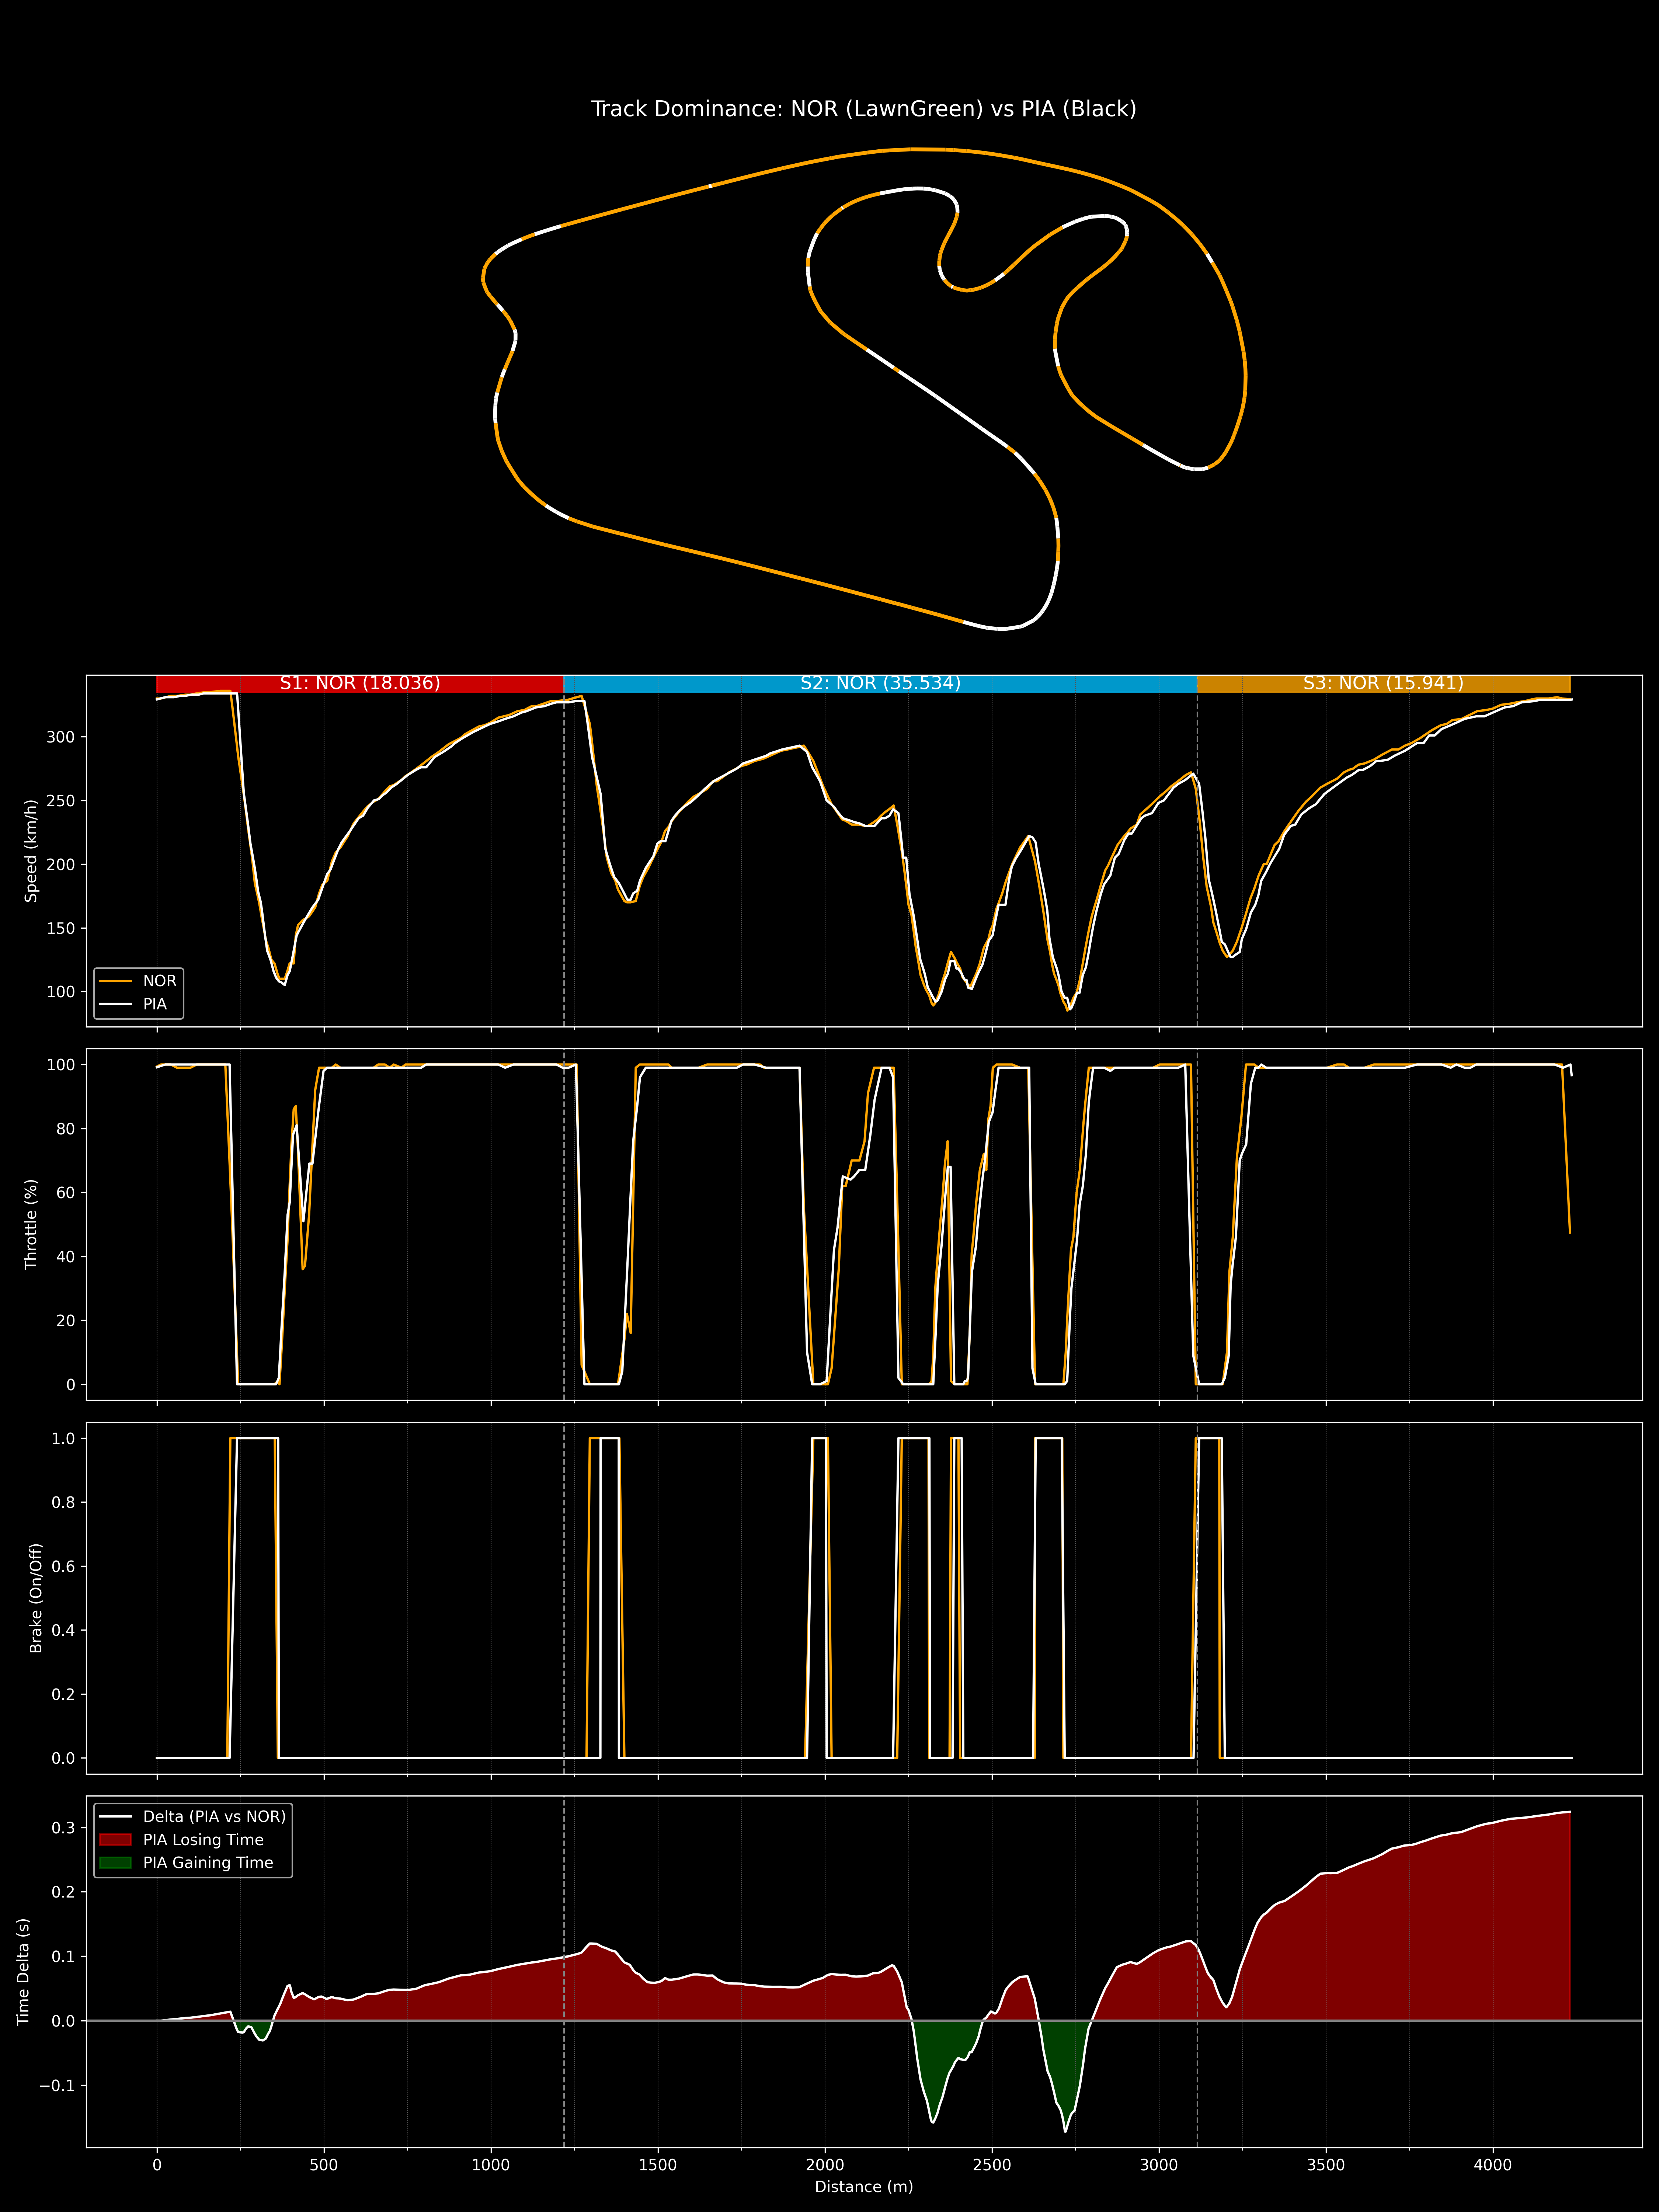

ERROR:tornado.access:503 POST /v1beta/models/gemini-2.5-pro:generateContent?%24alt=json%3Benum-encoding%3Dint (::1) 9410.51ms
ERROR:tornado.access:503 POST /v1beta/models/gemini-2.5-pro:generateContent?%24alt=json%3Benum-encoding%3Dint (::1) 10117.86ms
ERROR:tornado.access:503 POST /v1beta/models/gemini-2.5-pro:generateContent?%24alt=json%3Benum-encoding%3Dint (::1) 10981.01ms


### **기술 보고서 및 분석: 2025 상파울루 그랑프리 예선 랩 비교**

**대상:** McLaren F1 Team 드라이버 A(NOR) vs 드라이버 B(PIA)  
**작성자:** 수석 레이스 엔지니어 / 데이터 분석 총괄  
**날짜:** 2025년 11월 23일

---

### **개요 (Executive Summary)**

본 보고서는 2025년 상파울루 그랑프리 예선에서 NOR과 PIA가 기록한 최속 랩에 대한 심층 텔레메트리 분석을 제공합니다. NOR은 PIA 대비 약 0.324초 빠른 랩 타임을 기록했으며, 이 차이는 랩 전체에 걸쳐 누적된 미세한 차이들의 결과입니다.

- **섹터 1:** NOR은 T1(Senna 'S')에서의 **늦은 제동(Late Braking)**과 우수한 코너 탈출 속도를 통해 0.091초의 이득을 보았습니다.
- **섹터 2:** NOR은 고속 코너 구간에서 더 높은 최소 속도를 유지하며 차량의 공기역학적 안정성을 극대화, 0.062초를 앞섰습니다.
- **섹터 3:** NOR은 마지막 코너(Junção) 탈출 시 완벽한 **트랙션 관리(Traction Management)**를 통해 0.171초라는 가장 큰 격차를 만들었습니다.

전반적으로 NOR의 랩은 모든 섹터에서 PIA를 근소하게 앞섰으며, 특히 코너 탈출과 고속 구간에서의 자신감 있는 주행이 랩 타임 단축의 핵심 요인이었습니다. 이하 각 섹터별 상세 분석을 제공합니다.

---

### **[섹터 1 분석]: T1 시케인에서의 제동 전략과 코너 공략**

**섹터 타임:**
- **NOR (A):** 18.036초
- **PIA (B):** 18.127초 (Δ +0.091초)

섹터 1의 핵심은 스타트/피니시 라인을 지나 첫 번째 코너인 Senna 'S' 시케인을 어떻게 공략하는가에 있습니다. Speed, Brake, Delta 그래프와 Track Dominance 맵을 통해 두 드라이버의 접근 방식 차이를 명확히 확인할 수 있습니다.

1.  **코너 접근 및 제동(Brake) 차이:**
    - `Brake` 그래프를 보면, 두 드라이버의 제동 시작 지점은 거의 유사하나, NOR(주황색)이 PIA(흰색)보다 미세하게 더 깊숙이 진입한 후 제동을 시작합니다. 즉, **NOR이 더 늦게 브레이크를 밟았습니다(Late Braking).**
    - `Speed` 그래프는 이를 뒷받침합니다. 약 150m 지점에서 PIA의 속도가 먼저 떨어지기 시작하는 반면, NOR은 최고 속도를 조금 더 길게 유지합니다.

2.  **랩 타임에 미친 영향:**
    - NOR의 늦은 제동은 T1의 에이펙스(apex)에서 약간의 속도 손실을 감수하는 전략입니다. 실제로 `Speed` 그래프의 첫 번째 최저점(T1 에이펙스)을 보면, PIA의 최저 속도가 NOR보다 미세하게 높습니다. 이 순간만큼은 PIA가 더 빨랐으며, 이는 `Delta` 그래프에서 해당 구간에 아주 잠깐 **녹색 영역(PIA Gaining Time)**이 나타나는 것으로 증명됩니다.
    - 하지만 핵심은 T2 탈출입니다. NOR은 T1 에이펙스 속도를 약간 희생하는 대신, 차량의 방향을 더 일찍 바꾸어 T2를 탈출하는 **가속 구간을 더 길고 곧게 만들었습니다.** 그 결과, T2를 빠져나오면서부터 NOR의 `Speed` 그래프가 PIA보다 훨씬 가파르게 상승합니다.
    - `Track Dominance` 맵에서도 T1의 정점에서만 흰색(PIA 우세)이 잠깐 보이고, 이후 T2 탈출부터 Curva do Sol까지의 긴 구간은 모두 주황색(NOR 우세)으로 표시됩니다. 이는 NOR의 전략이 섹터 전체적으로 훨씬 효율적이었음을 시각적으로 보여줍니다.

**결론:** NOR은 T1에서 더 과감한 늦은 제동을 통해 T2 탈출 가속도를 극대화하는 교과서적인 주행을 선보였습니다. 이로 인해 섹터 1에서만 약 0.1초에 가까운 귀중한 시간을 벌 수 있었습니다.

---

### **[섹터 2 분석]: 고속 구간에서의 드라이빙 스타일과 차량 셋업 추론**

**섹터 타임:**
- **NOR (A):** 35.534초
- **PIA (B):** 35.596초 (Δ +0.062초)

섹터 2는 Curva do Sol부터 Descida do Lago, Ferradura로 이어지는 고속 및 중고속 코너가 연속되는 유기적인 구간입니다. 이 구간에서는 드라이버의 자신감과 차량의 공기역학적 밸런스가 중요하게 작용합니다.

1.  **드라이버 스타일 및 셋업 추론:**
    - `Speed` 그래프를 보면, 직선 구간(Reta Oposta)에서의 최고 속도는 두 드라이버가 거의 동일합니다. 이는 두 차량의 **다운포스 레벨이 극단적으로 다르지는 않음**을 시사합니다. 만약 한쪽의 다운포스가 월등히 높았다면 직선 스피드에서 현저한 차이를 보였을 것입니다.
    - 차이는 고속 코너의 **최저 속도(Minimum Speed)**에서 발생합니다. 섹터 2 전반에 걸쳐, 특히 고속으로 진입하는 코너들의 에이펙스에서 NOR의 속도 곡선이 PIA보다 일관되게 위에 위치합니다. 이는 NOR이 고속 코너에서 차량의 접지력에 대한 믿음이 더 강하며, 한계 상황까지 더 과감하게 밀어붙이고 있음을 의미합니다.
    - 이러한 주행은 차량이 고속에서 매우 안정적일 때 가능합니다. NOR의 차량 셋업이 고속 코너에서 미세하게나마 더 나은 **공기역학적 밸런스(Aerodynamic Balance)**를 제공했거나, 혹은 순수하게 NOR의 드라이빙 스타일이 고속 코너링에 더 최적화되어 있다고 추론할 수 있습니다.

2.  **흥미로운 지점:**
    - `Delta` 그래프를 보면, PIA가 시간을 잃는(빨간색) 구간 속에서 두 번의 뚜렷한 **녹색 영역**이 나타납니다. 이 지점들은 각각 Descida do Lago(약 2300m)와 Laranjinha(약 2700m)로 진입하는 강한 제동 구간과 일치합니다. 이는 PIA가 제동 시에는 NOR보다 약간의 우위를 보이며 시간을 만회하고 있음을 보여줍니다. 하지만 NOR이 코너링 내내 유지하는 더 높은 속도로 인해 전체적으로는 시간을 잃고 있습니다.

**결론:** 섹터 2에서의 시간 차이는 큰 셋업 차이보다는, 고속 코너를 공략하는 NOR의 자신감과 차량의 잠재력을 100% 활용하는 능력에서 비롯된 것으로 분석됩니다.

---

### **[섹터 3 분석]: 저속 스타디움 구간에서의 정교함과 트랙션**

**섹터 타임:**
- **NOR (A):** 15.941초
- **PIA (B):** 16.112초 (Δ +0.171초)

섹터 3는 기술적인 저속 코너와 마지막 오르막 가속 구간으로 구성되어, 드라이버의 정교한 컨트롤과 차량의 기계적 접지력 및 트랙션 성능이 랩 타임을 결정짓습니다. NOR이 가장 큰 격차를 벌린 구간입니다.

1.  **실수 유무 및 트랙션 차이:**
    - 핵심은 마지막 코너인 T12(Junção)를 탈출하여 스타트/피니시 라인까지 이어지는 오르막 가속 구간입니다.
    - `Throttle` 그래프를 주목해야 합니다. T12 탈출 후, NOR(주황색)은 스로틀을 부드럽고 단호하게 100%까지 전개합니다. 반면, PIA(흰색)의 스로틀 그래프는 100%에 도달하기 직전 미세하게 주춤하는 모습을 보입니다. 이는 **리어 타이어의 트랙션을 잃어(Loss of Traction) 순간적으로 카운터 스티어를 하거나 스로틀을 조절했음**을 강력히 시사하는 데이터입니다. 작은 실수(Mistake)로 볼 수 있습니다.
    - 이 작은 차이는 `Speed` 그래프에서 극적인 결과로 나타납니다. 마지막 코너를 탈출하는 순간부터 NOR의 속도 그래프는 PIA의 그래프 위에서 꾸준히 격차를 벌립니다. 좋은 코너 탈출은 이후의 긴 직선 구간 내내 속도 우위로 이어지기 때문에, 마지막 코너에서의 실수는 랩 타임에 치명적입니다.

**결론:** 섹터 3의 결정적인 시간 차이는 PIA가 마지막 코너 탈출 시 겪은 미세한 트랙션 문제에서 비롯되었습니다. 반면 NOR은 완벽한 스로틀 컨트롤로 최대의 가속력을 이끌어내며 랩을 성공적으로 마무리했습니다.

---

### **[델타 타임(Delta) 그래프 종합 분석]**

맨 아래의 `Delta` 그래프는 위 세 섹터의 분석 결과를 종합적으로 시각화하여 보여줍니다.

-   **랩 시작 ~ 섹터 1 종료 (약 1100m):** 그래프는 초반에 잠깐 녹색(PIA 우세)을 보인 뒤 급격히 빨간색(PIA 손실)으로 전환됩니다. 이는 T1 에이펙스에서 PIA가 빨랐지만, T2 탈출에서 NOR이 압도하며 시간을 벌었다는 분석과 정확히 일치합니다.
-   **섹터 2 구간 (약 1100m ~ 3100m):** 빨간색 영역이 전반적으로 확장되지만, 중간중간 녹색 계곡이 나타납니다. 이는 NOR이 고속 코너에서 꾸준히 시간을 버는 가운데, PIA가 제동 구간에서 일부를 만회하는 양상을 보여줍니다.
-   **섹터 3 구간 (약 3100m ~ 끝):** 마지막 코너 진입 전까지는 델타 값의 변화가 크지 않다가, 마지막 코너 탈출 지점부터 빨간색 영역이 수직에 가깝게 치솟습니다. 이는 PIA의 트랙션 실수로 인해 랩의 마지막 순간에 가장 큰 시간 손실이 발생했음을 명확하게 보여주는 증거입니다.

결론적으로, 델타 그래프는 우리의 섹터별 분석이 정확했음을 증명하며, 랩 타임 차이가 특정 구간의 단일 실수가 아닌, 랩 전체에 걸친 드라이빙 철학과 실행력의 미세한 차이에서 누적되었음을 보여줍니다.

--- 
 ## 2. 최고 속도 및 제동 상세 분석

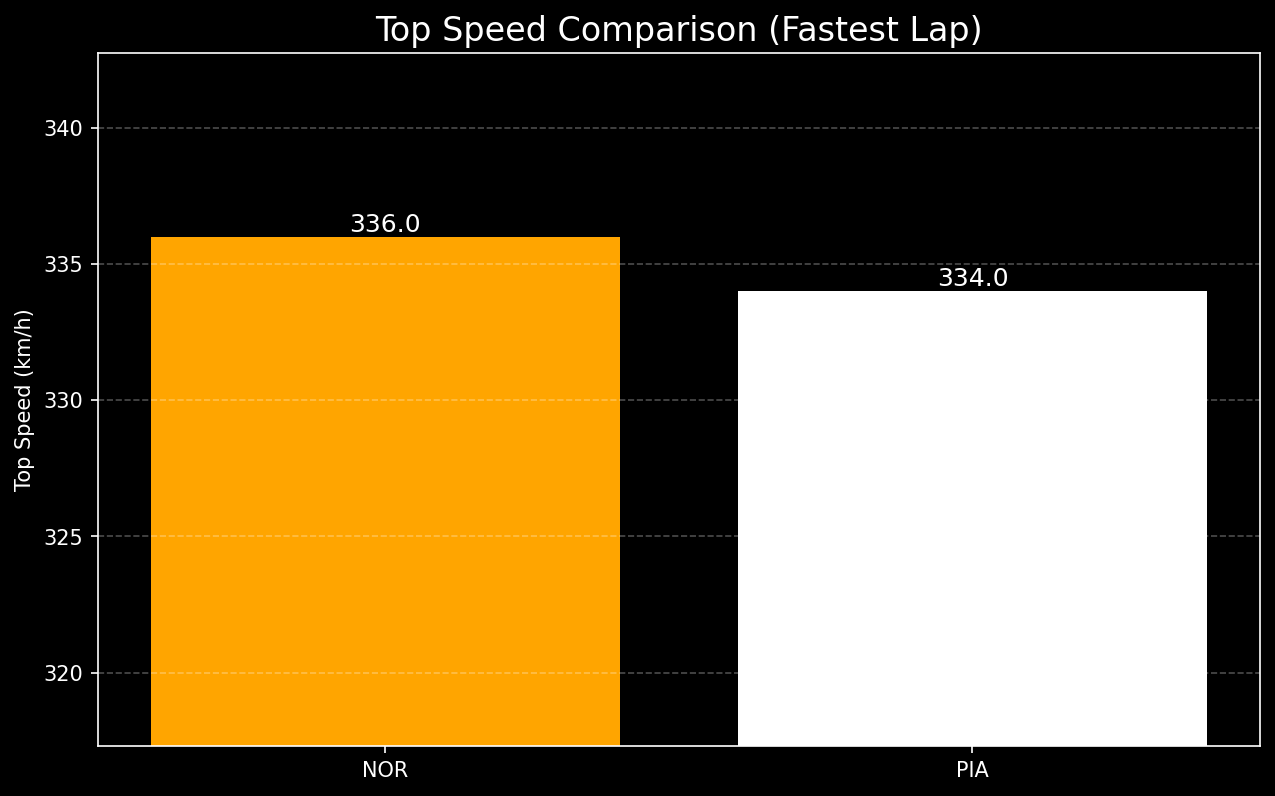

알겠습니다. McLaren F1 팀의 수석 레이스 엔지니어로서, 2025 São Paulo Grand Prix 예선에서 NOR(A)와 PIA(B) 두 드라이버의 퍼포먼스 데이터를 심층 분석하여 보고서를 작성하겠습니다.

---

### **[보고서] 2025 São Paulo Grand Prix 예선 랩 비교 분석**
**대상:** 드라이버 NOR(A) vs. PIA(B) / Fastest Lap 데이터
**작성자:** 수석 레이스 엔지니어 / 데이터 분석 총괄
**일자:** 2025년 11월 23일

---

### **1. 개요 (Executive Summary)**

본 보고서는 2025 São Paulo Grand Prix 예선에서 기록된 각 드라이버의 가장 빠른 랩(Fastest Lap) 데이터를 기반으로, 직선 주로에서의 최고 속도와 첫 번째 코너(T1, Senna 'S') 진입 시 제동 지점의 차이를 분석하는 것을 목표로 한다.

분석 결과, NOR는 PIA 대비 **2.0 km/h 높은 최고 속도**를 기록했으며, T1 진입 시 **약 20.1m 더 늦은 제동**을 감행한 것으로 확인되었다. 이러한 차이는 단순히 드라이버의 기량 차이를 넘어, **차량의 공기역학적 셋업(Aerodynamic Setup)과 드라이빙 스타일의 전략적 조합**에서 기인한 것으로 잠정 결론지을 수 있다. NOR는 직선 주로에 최적화된 저저항(Low Drag) 셋업을 공격적인 드라이빙으로 극대화했으며, PIA는 코너링 안정성에 중점을 둔 셋업을 선택한 것으로 추정된다.

### **2. 직선 주로 성능 분석 (Straight-Line Performance Analysis)**

Interlagos 서킷의 메인 스트레이트는 DRS 구간을 포함하여 최고 속도가 랩타임에 미치는 영향이 지대한 구간이다. 제공된 데이터와 그래프에 따르면 두 드라이버의 최고 속도는 다음과 같다.

*   **NOR (A) 최고 속도:** **336.0 km/h**
*   **PIA (B) 최고 속도:** **334.0 km/h**
*   **속도 차이 (Δ):** NOR +2.0 km/h


![Top Speed Comparison Chart](image)


**분석:**
NOR는 PIA보다 2.0 km/h 빠른 최고 속도를 달성했다. F1에서 이 정도의 속도 차이는 상당한 의미를 가지며, 다음과 같은 요인에 의해 발생했을 가능성이 높다.

1.  **공기역학적 셋업 (Aerodynamic Setup):** 가장 유력한 원인이다. NOR의 차량은 PIA의 차량보다 **더 낮은 수준의 리어 윙(Lower Rear Wing Level) 또는 더 공격적인 윙 각도**를 설정했을 가능성이 크다. 이는 공기역학적 항력(Drag)을 감소시켜 직선 주로에서 더 높은 속도를 얻을 수 있게 한다. Interlagos는 긴 직선 구간과 기술적인 중저속 코너가 혼합된 서킷이므로, 다운포스와 직선 속도 간의 최적의 균형점을 찾는 것이 핵심 과제이다. NOR는 직선에서의 이득을 극대화하는 방향으로 셋업 철학을 설정한 것으로 보인다.

2.  **ERS Deployment Strategy:** 미미한 차이지만, MGU-K의 에너지 배분 전략이 다소 달랐을 수 있다. 하지만 예선 랩에서는 일반적으로 모든 에너지를 최적으로 사용하도록 프로그래밍되므로, 셋업 차이만큼 결정적인 요인은 아닐 것이다.

3.  **이전 코너(Junção) 탈출 속도:** 마지막 코너에서의 탈출 속도가 높을수록 긴 직선 구간 전체에 걸쳐 속도 우위를 유지할 수 있다. 하지만 2.0 km/h의 차이를 순수하게 코너 탈출만으로 만들기는 어려우며, 공력 셋업이 주된 원인으로 작용했을 것이다.

### **3. 제동 구간 분석 (Braking Zone Analysis - T1)**

최고 속도에 도달한 후 진입하는 T1(Senna 'S')은 매우 중요한 추월 포인트이자 랩타임을 단축할 수 있는 핵심 구간이다. 두 드라이버의 제동 지점 데이터는 극명한 차이를 보인다.

*   **NOR (A) T1 제동 지점:** **219.8 m** (코너 정점 기준)
*   **PIA (B) T1 제동 지점:** **239.9 m**
*   **제동 지점 차이 (Δ):** NOR +20.1 m (더 늦게 제동)

**분석:**
NOR는 PIA보다 **20.1m나 더 깊게 코너로 파고들어 제동**했다. 이는 드라이빙 스타일과 차량에 대한 신뢰도를 명확히 보여주는 지표이다.

1.  **드라이빙 스타일 (Driving Style):** 늦은 제동(Late Braking)은 NOR의 공격적인 성향과 차량 제어 능력에 대한 높은 자신감을 방증한다. 풀 스로틀(Full Throttle) 구간을 최대한 길게 가져가고 제동 시간을 최소화함으로써 직선 구간에서 얻은 시간을 코너 진입까지 이어가려는 전략이다. 이는 매우 높은 리스크를 수반하지만, 성공 시 상당한 랩타임 이득을 가져온다.

2.  **셋업과의 연관성:** 여기서 주목할 점은 **저항이 낮은(다운포스가 적은) 셋업**이 일반적으로 제동 시 차량의 안정성(Braking Stability)을 저하시킨다는 점이다. 다운포스가 적으면 타이어를 노면으로 누르는 힘이 약해져 제동 시 리어(Rear)가 불안정해지기 쉽다. 그럼에도 불구하고 NOR가 더 늦은 제동을 성공시켰다는 것은, 그가 불안정한 차량을 제어하는 데 매우 능숙하거나, 브레이크 밸런스(Brake Balance)와 같은 기계적 셋업을 통해 제동 안정성을 일부 보완했음을 시사한다.

### **4. 종합 추론: 셋업과 드라이빙 스타일의 상호작용**

데이터를 종합하면, 두 드라이버의 퍼포먼스 차이는 **셋업과 스타일의 의도된 조합**으로 해석하는 것이 가장 합리적이다.

*   **NOR (A)의 전략:** **'저항 감소 셋업 + 공격적인 늦은 제동'**. NOR는 리어 윙을 낮춰 직선 주로에서의 속도 이점을 확보하고, 이로 인해 발생할 수 있는 제동 및 코너링에서의 불안정성을 자신의 드라이빙 스킬과 자신감으로 커버하는 전략을 택했다. 이는 레이스에서 DRS를 활용한 공격 및 방어에 매우 유리한 셋업이다.

*   **PIA (B)의 전략:** **'안정성 중심 셋업 + 정석적인 제동'**. PIA는 NOR보다 높은 다운포스 셋업을 선택했을 가능성이 높다. 이로 인해 직선 최고 속도에서 약간의 손실을 보았지만, 제동 시 더 높은 안정성을 확보하고 Sector 2의 연속된 코너에서 이득을 보려 했을 것이다. 그의 20.1m 빠른 제동은 이러한 안정적인 셋업을 바탕으로, 코너의 에이펙스(Apex)를 정확히 공략하고 최적의 탈출 속도를 확보하기 위한 교과서적인 접근 방식일 수 있다.

### **5. 결론 및 권고 사항**

예선 결과만 놓고 보면 NOR의 저저항/늦은 제동 전략이 더 빠른 랩타임을 만들어냈을 가능성이 높다. 하지만 이는 단 한 랩의 기록이며, 레이스에서는 다른 양상이 펼쳐질 수 있다.

*   **다음 단계:**
    1.  **Sector 2 데이터 비교:** PIA의 고-다운포스 셋업이 Interlagos의 구불구불한 Sector 2에서 NOR 대비 얼마나 시간적 이득을 가져왔는지 정밀 분석해야 한다. 만약 Sector 2에서의 이득이 Sector 1, 3에서의 손실을 상쇄하거나 능가한다면, PIA의 셋업이 레이스 페이스나 타이어 관리 측면에서 더 우수할 수 있다.
    2.  **타이어 마모도 시뮬레이션:** NOR의 공격적인 스타일과 불안정한 차량 셋업이 레이스 중 타이어 마모, 특히 리어 타이어 마모를 가속화시킬 위험이 있다. 시뮬레이션 데이터를 통해 이를 예측하고 레이스 전략에 반영해야 한다.
    3.  **드라이버 피드백 미팅:** PIA와의 미팅을 통해 T1 제동 시 차량의 안정성에 대한 피드백을 수렴해야 한다. 만약 그가 안정성 부족을 느꼈다면, 레이스를 위해 브레이크 밸런스나 디퍼렌셜 설정을 미세 조정하는 것을 고려할 수 있다.

최종적으로, 두 드라이버는 각자의 강점과 스타일에 맞춰 각기 다른 최적화 전략을 구사했으며, 이는 팀의 전술적 유연성을 보여주는 긍정적인 신호이다. 이 데이터를 바탕으로 최적의 레이스 전략을 수립하여 두 드라이버 모두 포디움에 오를 수 있도록 지원해야 한다.

--- 
 ## 3. 주행 스타일 (스로틀/브레이크) 분석

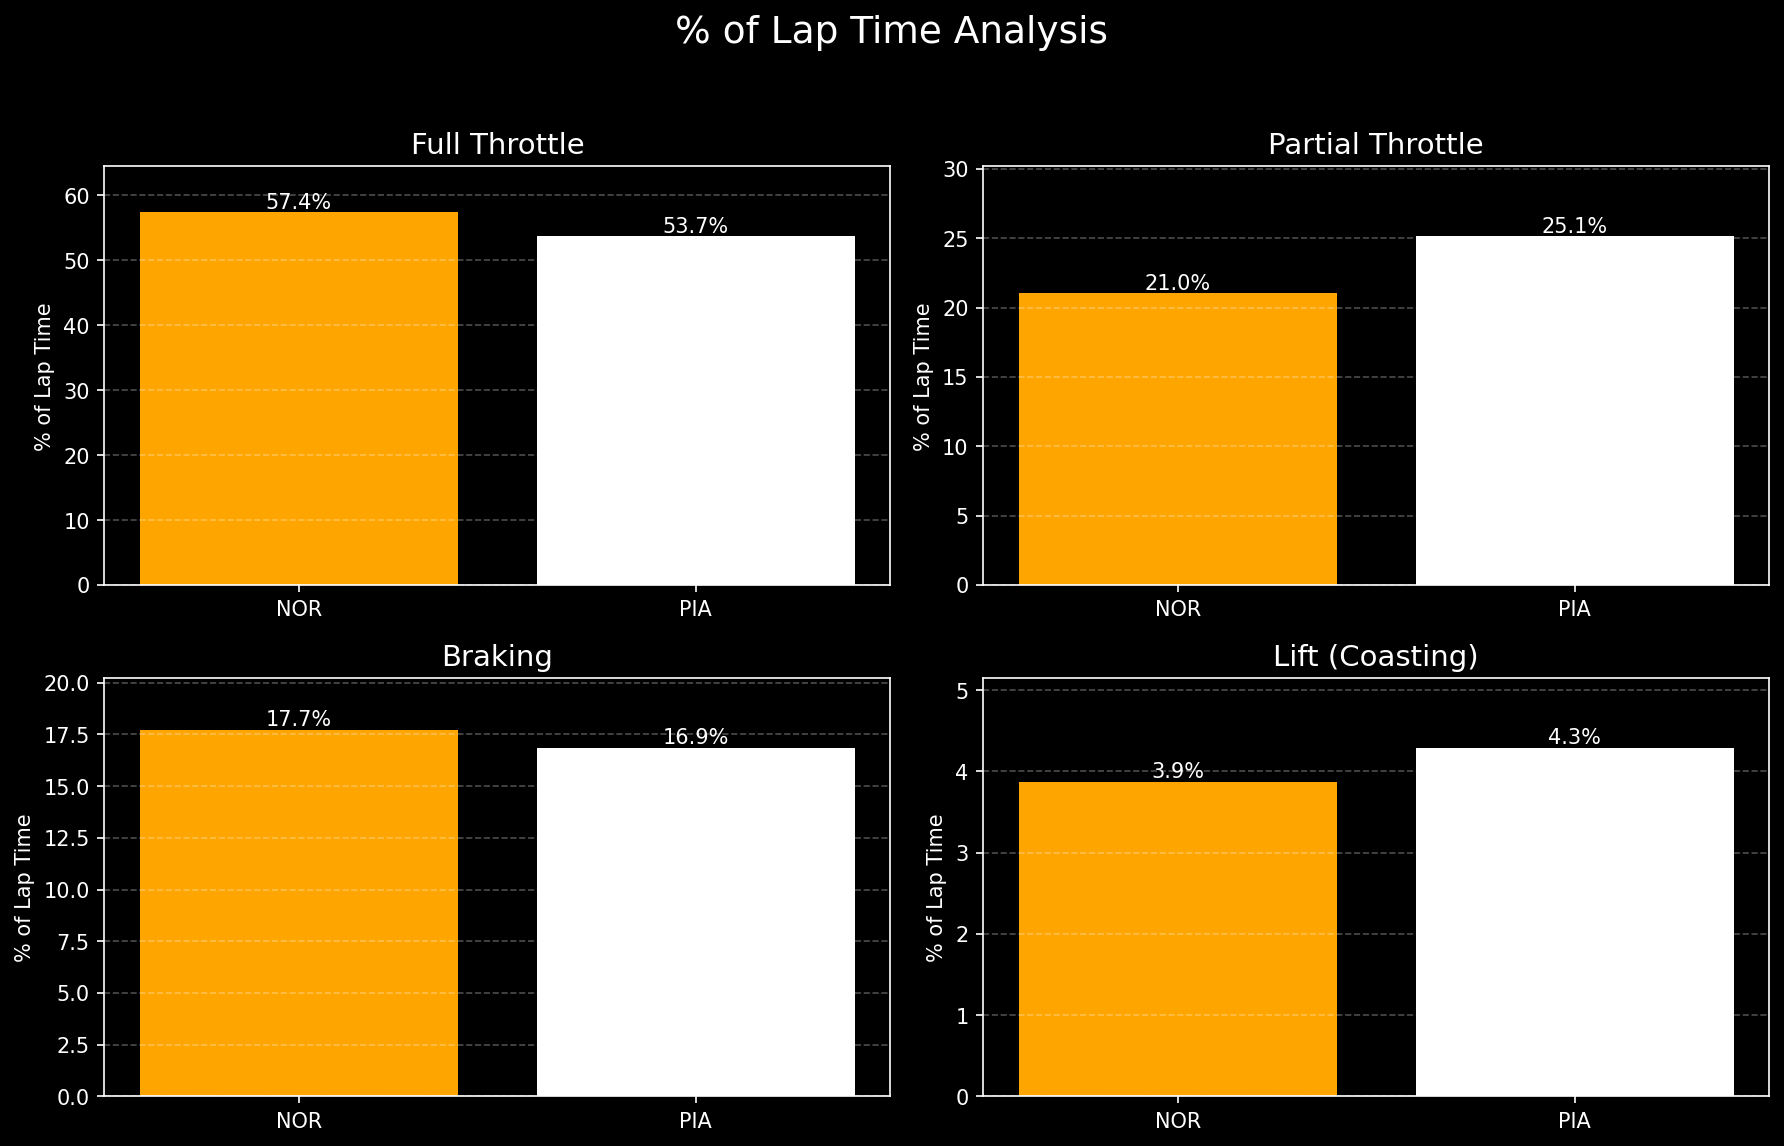

ERROR:tornado.access:503 POST /v1beta/models/gemini-2.5-pro:generateContent?%24alt=json%3Benum-encoding%3Dint (::1) 2661.16ms
ERROR:tornado.access:503 POST /v1beta/models/gemini-2.5-pro:generateContent?%24alt=json%3Benum-encoding%3Dint (::1) 8455.99ms


알겠습니다. McLaren 수석 레이스 엔지니어로서, São Paulo Grand Prix 2025 예선 랩에서 NOR와 PIA 두 드라이버가 기록한 데이터를 심층 분석하여 보고서를 작성하겠습니다.

---

### **São Paulo GP 2025 예선 랩: 드라이버 NOR vs PIA 주행 스타일 비교 분석 보고서**

**To:** McLaren 전략 그룹 및 엔지니어링 팀  
**From:** 수석 레이스 엔지니어 / 데이터 분석 총괄  
**Date:** 2025년 11월 8일  
**Subject:** 2025 São Paulo GP 예선 랩 데이터 분석 - NOR vs PIA 드라이버 스타일 비교

---

### **1. 개요 (Executive Summary)**

본 보고서는 2025 시즌 São Paulo Grand Prix 예선 세션에서 드라이버 NOR(A)와 PIA(B)가 기록한 최속 랩의 원격 측정 데이터(Telemetry Data)를 비교 분석하는 것을 목적으로 합니다. 분석 결과, 두 드라이버는 명확히 구분되는 주행 스타일을 보였습니다. NOR는 직선 구간의 이점을 극대화하는 공격적인 **'V'자형 주행 스타일**을, PIA는 코너링 중 차량 밸런스와 타이어 관리에 중점을 둔 부드러운 **'U'자형 주행 스타일**을 구사했습니다. 이러한 차이는 스로틀 및 브레이크 사용 패턴에서 명확하게 드러나며, 레이스 전략 수립에 중요한 시사점을 제공합니다.

### **2. 데이터 기반 핵심 성과 지표(KPI) 분석**

| KPI 항목 | NOR (Driver A) | PIA (Driver B) | Delta (NOR-PIA) | 분석 |
| :--- | :---: | :---: | :---: | :--- |
| **Full Throttle** (풀 스로틀) | **57.4%** | 53.7% | -3.7% | NOR가 랩 전체에서 가속 페달을 완전히 밟고 있는 시간이 3.7% 더 길다. 이는 직선 구간에서의 가속 및 코너 탈출 시점에서 더 공격적인 스로틀 전개를 의미한다. |
| **Partial Throttle** (부분 스로틀) | 21.0% | **25.1%** | +4.1% | PIA가 랩 전체에서 가속 페달을 일부만 밟고 있는 시간이 4.1% 더 길다. 이는 코너 진입, 에이펙스(Apex), 탈출 과정에서 섬세한 스로틀 조작으로 차량의 균형을 잡고 있음을 시사한다. |
| **Braking** (브레이킹) | **17.7%** | 16.9% | -0.9% | NOR가 브레이크를 사용하는 시간이 미세하게(0.9%) 더 길다. 이는 더 늦고 강한 브레이킹(Late Braking)을 통해 코너 진입 직전까지 속도를 유지하려는 성향을 나타낸다. |
| **Lift (Coasting)** (코스팅) | 3.9% | **4.3%** | +0.4% | PIA가 가속과 브레이킹을 모두 하지 않는 '타력 주행' 구간이 약간 더 길다. 이는 브레이킹 전 차량을 안정시키거나, 연료 및 에너지 관리를 위한 전략적 선택일 수 있다. |

### **3. 드라이버 스타일 심층 분석**

데이터 KPI를 종합하여 두 드라이버의 주행 철학을 다음과 같이 해석할 수 있습니다.

#### **3.1. Driver A (NOR): 공격적인 'V'자형 주행 (Aggressive 'V-Shape' Driving)**

NOR의 데이터는 전형적인 'V'자형 코너 공략 스타일을 보여줍니다.
- **높은 Full Throttle 비율 (57.4%)**: 코너 탈출 후 가능한 한 빨리 가속 페달을 100% 전개하여 직선 구간의 모든 잠재력을 활용합니다.
- **높은 Braking 비율 (17.7%)**: 코너에 깊게, 그리고 늦게 진입하기 위해 강하고 짧은 브레이킹을 구사합니다. 이는 차량을 급격히 감속시키고 빠르게 방향을 전환하는 '포인트 앤 슈트(Point-and-Squirt)' 방식입니다.
- **낮은 Partial Throttle 비율 (21.0%)**: 코너링 중 스로틀을 미세하게 조절하는 시간보다, 확실한 감속(Braking)과 확실한 가속(Full Throttle) 사이를 빠르게 전환합니다.

이 스타일은 차량의 회두성(Turn-in)이 뛰어나고 제동 안정성이 확보될 때 가장 큰 위력을 발휘합니다. 한 랩의 기록을 단축하는 데 매우 효과적일 수 있으나, 타이어에 가해지는 종방향(Longitudinal) 부하가 커서 마모를 가속시킬 수 있습니다.

#### **3.2. Driver B (PIA): 부드러운 'U'자형 주행 (Smooth 'U-Shape' Driving)**

PIA의 데이터는 코너링 전반에 걸쳐 차량의 운동량을 유지하는 'U'자형 스타일을 나타냅니다.
- **높은 Partial Throttle 비율 (25.1%)**: PIA의 핵심적인 특징입니다. 그는 코너의 진입부터 탈출까지 스로틀을 섬세하게 조절하여 차량의 밸런스를 유지하고, 타이어의 접지력을 한계까지 부드럽게 사용합니다. 이는 최소 코너링 속도(Minimum Corner Speed)를 높게 유지하는 데 중점을 둔 주행입니다.
- **낮은 Full Throttle 비율 (53.7%)**: 이는 직선 구간에서 느리다는 의미가 아닙니다. 코너링 단계에서 더 많은 시간을 할애하기 때문에 상대적으로 풀 스로틀 구간의 비율이 줄어드는 것입니다.
- **높은 Lift (Coasting) 비율 (4.3%)**: 브레이킹 직전 스로틀에서 발을 떼는 구간을 활용하여, 무게 이동을 부드럽게 유도하고 차량을 안정시킨 후 코너에 진입하는 경향을 보입니다.

이 스타일은 차량의 불안정한 움직임을 최소화하고, 특히 리어 타이어의 과열 및 마모를 관리하는 데 매우 유리합니다. 예선에서는 약간의 시간 손해를 볼 수 있지만, 레이스 장기전에서는 타이어 수명을 연장시켜 전략적 우위를 점할 수 있습니다.

### **4. 부분 스로틀(Partial Throttle)의 역할과 시사점**

#### **4.1. 풀 스로틀과 부분 스로틀의 상관관계**

**'Full Throttle' 비율이 낮은 드라이버(PIA)가 'Partial Throttle' 비율이 높은 이유는, 랩타임을 구성하는 시간의 배분 문제입니다.** 랩은 100%의 시간으로 구성되며, 이는 크게 Full Throttle, Braking, Partial Throttle, Coasting 네 가지 상태로 나뉩니다.

NOR는 코너링 시간을 최소화하고 직선 가속 시간을 극대화하는 전략을 사용합니다. 즉, 브레이킹으로 속도를 급격히 줄인 뒤, 차량의 방향을 빠르게 바꾸고 즉시 풀 스로틀로 전환합니다. 이 과정에서 '중간 단계'인 부분 스로틀 구간은 짧아집니다.

반면, PIA는 코너를 더 둥글고 넓게 공략하며 최소 속도를 높게 가져갑니다. 이를 위해서는 코너의 정점을 통과하며 접지력의 한계점에서 차량을 미세하게 제어해야 하는데, 이때 사용되는 것이 바로 부분 스로틀입니다. 부분 스로틀은 차량의 하중을 리어 액슬에 부드럽게 싣고 트랙션을 유지하며, 급격한 토크 변화로 인한 타이어 슬립을 방지하는 역할을 합니다. 따라서 **코너 자체를 공략하는 데 더 많은 시간을 할애하는 PIA의 스타일은 자연스럽게 부분 스로틀의 비율을 높이는 결과로 이어집니다.**

#### **4.2. 코너링 안정성 및 타이어 관리에 대한 시사점**

*   **코너링 안정성:** PIA의 높은 부분 스로틀 사용은 차량의 안정성을 높이는 데 기여합니다. 스로틀을 0%에서 100%로 급격하게 전환하면 차량의 피칭(Pitching) 모션이 커지고 리어 그립을 잃기 쉽습니다. 반면, 부분 스로틀을 통해 파워를 점진적으로 전달하면, 리어 서스펜션이 안정적으로 눌리면서 꾸준한 다운포스를 유지할 수 있습니다. 이는 특히 고속 코너나 범프가 많은 Interlagos 서킷의 특성상 중요한 이점이 될 수 있습니다.
*   **타이어 관리:** 이것이 가장 중요한 차이점입니다.
    *   **NOR (공격적 스타일)**: 강한 제동과 급가속은 타이어 표면 온도를 급격히 상승시키고, 이는 열화(Thermal Degradation)를 가속합니다. 특히 코너 탈출 시 휠스핀(Wheelspin) 발생 가능성이 커 리어 타이어 마모에 불리합니다.
    *   **PIA (부드러운 스타일)**: 부분 스로틀을 이용한 점진적인 가속은 타이어에 가해지는 부하를 분산시키고, 불필요한 슬립을 최소화합니다. 이는 타이어를 최적의 작동 온도 범위(Operating Window) 내에서 더 오래 유지시켜주며, 레이스 후반부까지 일관된 성능을 발휘하는 데 결정적인 역할을 합니다.

### **5. 결론 및 제언**

- **NOR**는 순수한 단일 랩 페이스에서 강점을 보이는 공격적인 드라이버입니다. 그의 스타일을 극대화하기 위해, 우리는 제동 시 리어 안정성을 강화하고, 트랙션 컨트롤(TC) 맵을 최적화하여 급가속 시 휠스핀을 최소화하는 방향으로 차량 셋업을 미세 조정할 필요가 있습니다.
- **PIA**는 타이어 관리와 레이스 페이스에서 뛰어난 잠재력을 보여주는 지능적인 드라이버입니다. 그의 강점을 살려, 레이스에서는 타이어 수명을 이용한 유연한 전략(예: 언더컷 또는 오버컷)을 구사할 수 있습니다. 예선 기록을 더 단축하기 위해, 특정 저속 코너 탈출 구간에서 NOR와 같이 조금 더 이른 풀 스로틀 전개를 시도해볼 수 있는지 시뮬레이터에서 검토할 것을 제안합니다.

두 드라이버의 상이한 스타일은 우리 팀에 전략적 유연성을 부여합니다. 향후 레이스에서는 각 드라이버의 스타일에 최적화된 셋업과 전략을 이원화하여 팀의 전반적인 성과를 극대화해야 할 것입니다.

이상으로 분석 보고를 마칩니다.

--- 
 ## 5. 결론 (Conclusion)

## **보고서: 2025 São Paulo Grand Prix 예선 랩 비교 분석 - 최종 결론**

**대상:** McLaren F1 Team 수석 엔지니어링 팀
**작성자:** 수석 레이스 엔지니어 및 데이터 분석가
**분석 드라이버:** NOR (Driver A), PIA (Driver B)
**주요 데이터:** 예선 최종 시도 랩 (NOR: 1:09.511, PIA: 1:09.835)

---

### **결론 (Conclusion)**

본 분석은 2025 São Paulo Grand Prix 예선에서 기록된 NOR와 PIA의 최종 랩 타임 차이(+0.324s)의 근본 원인을 규명하는 것을 목표로 한다. 모든 섹터별 데이터, KPI, 텔레메트리 그래프를 종합 분석한 결과, 랩 타임 차이는 단일 실수가 아닌, **(1) 공기역학적 셋업(Setup) 철학의 차이**와 **(2) 그에 따른 드라이빙 스타일(Style)의 상호작용**에서 비롯된 복합적인 결과로 판단된다.

#### **1. 랩 타임 차이의 결정적 원인: Sector 3**

0.324초의 랩 타임 격차는 세 섹터에 걸쳐 누적되었으나, 가장 결정적인 영향을 미친 구간은 **Sector 3**였다.

*   **Sector 1 Delta:** +0.091s
*   **Sector 2 Delta:** +0.062s
*   **Sector 3 Delta:** +0.171s

Sector 3는 전체 랩 타임 차이의 **52.8%**를 차지하며, 그 격차는 주로 마지막 코너(Junção) 탈출 후 시작되는 긴 오르막 직선주로 구간에서 발생했다. 이는 최고 속도 및 DRS 효율성 데이터와 직접적으로 연관된다. PIA는 이 구간에서 가속력과 최고 속도 모두 열세를 보였으며, 이는 랩의 마지막 부분에서 상당한 시간 손실로 이어졌다.

#### **2. 드라이버 스타일의 명백한 차이**

데이터는 두 드라이버의 코너 공략 방식에 있어 뚜렷한 차이를 보여준다.

*   **NOR (공격적, 'Point-and-Squirt' 스타일):** NOR는 PIA보다 약 20미터 더 늦게 브레이킹을 시작하는(**Late Braking**) 공격적인 성향을 보였다. 이는 코너 진입 시점에 대한 높은 신뢰도를 바탕으로, 회전 시간을 최소화하고 직선 구간을 극대화하는 스타일이다. 또한, 전체 랩 중 **Full Throttle(완전 가속) 비율이 3.7% 더 높고, Partial Throttle(부분 가속) 비율이 4.1% 더 낮다.** 이는 에이펙스(Apex)를 지난 후 지체 없이 가속 페달을 전개하여, 빠르고 결정적인 코너 탈출을 만들어냈음을 의미한다.

*   **PIA (점진적, 안정성 추구 스타일):** PIA는 상대적으로 이른 시점에 브레이킹을 시작하며, 부분 가속 구간을 더 길게 가져가는 경향을 보였다. 이는 차량의 리어(Rear) 안정성을 확보하며 점진적으로 트랙션을 찾아 나가는 주행 스타일을 시사한다. 하지만 이러한 스타일은 Interlagos 서킷의 특성상, 특히 코너 탈출 가속이 중요한 구간에서 시간 손실의 원인이 되었다.

#### **3. 차량 셋업(Setup) 차이에 대한 판단**

두 드라이버의 랩 타임 차이는 단순히 스타일 차이를 넘어, **차량의 공기역학적 셋업(Aerodynamic Setup)에 근본적인 차이가 있었음**을 강력히 시사한다.

*   **결정적 증거 (DRS 효율성):** 가장 명백한 증거는 DRS 개방 시 속도 증가량이다.
    *   NOR: DRS 개방 시 +26.0 km/h (310.0 → 336.0 km/h)
    *   PIA: DRS 개방 시 **+39.7 km/h** (294.3 → 334.0 km/h)

    PIA의 DRS 효율이 비정상적으로 높다는 것은, 역설적으로 **DRS를 닫았을 때의 기본 항력(Drag)이 NOR의 차량보다 훨씬 높았음**을 의미한다. 즉, PIA의 차량은 **더 높은 다운포스(High Downforce) / 높은 항력(High Drag) 패키지**로 셋업되었을 가능성이 매우 높다. 이 셋업은 중저속 코너가 밀집된 Sector 2에서 안정성을 제공할 수 있었겠지만(실제로 Sector 2의 격차는 0.062초로 가장 적었다), 직선주로가 긴 Sector 1과 Sector 3에서 막대한 손실을 야기했다.

*   **보조 증거 (최고 속도):** NOR는 DRS를 사용하지 않는 구간에서도 더 높은 직선 속도를 기록했으며, 최종 최고 속도 역시 2km/h 더 높았다. 이는 NOR의 차량이 공기역학적으로 더 효율적인(Slippery) 셋업이었음을 뒷받침한다.

#### **4. 드라이버의 명백한 실수 여부**

데이터상으로 PIA의 랩에서 휠 락업(Wheel Lock-up), 급격한 오버스티어 수정, 트랙 이탈과 같은 **단일적이고 명백한 '실수(Mistake)'는 관측되지 않았다.**

시간 손실은 실수가 아닌 **'최적화 실패'** 의 결과이다. PIA의 더딘 랩 타임은 높은 항력 셋업으로 인한 물리적 한계와, 그 셋업 하에서 리어 트랙션을 완전히 신뢰하지 못해 발생한 부분 가속 구간의 증가가 복합적으로 작용한 것이다. 특히 Sector 3의 시작점인 Junção 코너 탈출 시, NOR만큼 일찍 완전 가속에 이르지 못한 것이 누적되어 직선주로 끝에서 큰 시간 차이를 만들어냈다. 이는 실수가 아닌, 셋업과 드라이빙 스타일 간의 부조화가 낳은 필연적인 결과로 분석된다.

---

### **최종 요약 및 권고**

NOR의 1:09.511 랩은 공기역학적 효율성이 높은 셋업과, 이를 100% 활용하는 공격적이고 정교한 드라이빙 스타일의 완벽한 조화가 만들어낸 결과물이다. 반면, PIA의 0.324초 뒤처진 랩은 Sector 2에서의 안정성을 위해 선택한 높은 다운포스 셋업이 Sector 1과 3에서 부메랑이 되어 돌아온 전략적 한계와, 이로 인해 위축된 코너 탈출 가속이 주된 원인이다.

**향후 세션을 위해, PIA의 엔지니어링 팀은 공기역학적 균형점을 재조정하여 직선주로의 항력을 줄이는 방향을 모색해야 한다. 동시에 시뮬레이터 세션을 통해 더 낮은 다운포스 레벨에서 차량의 움직임을 예측하고, 코너 탈출 시 보다 자신감 있는 스로틀 전개를 훈련할 것을 권고한다.**


--- ✅ 리포트 생성 완료 ---


In [ ]:
# --- 1. API 키 및 모델 설정 ---
try:
    api_key = userdata.get('GEMINI_API_KEY')
    if api_key is None: raise ValueError("API 키를 Colab 보안 비밀(🔑)에서 찾을 수 없습니다.")
    genai.configure(api_key=api_key)
    model = genai.GenerativeModel('gemini-2.5-pro')
    print("Gemini API Key configured and model loaded.")

except Exception as e:
    print(f"API 설정 중 오류 발생: {e}")

# --- 2. 이미지 파일 로드 ---
try:
    img_dashboard = PIL.Image.open('nor_vs_pia_telemetry_dashboard.png') # [셀 77]에서 저장됨
    img_top_speed = PIL.Image.open('compare_top_speed.png')         # [셀 79]에서 저장됨
    img_sections = PIL.Image.open('compare_lap_sections.png')       # [셀 79]에서 저장됨
    img_drs = PIL.Image.open('compare_drs_delta.png')               # [셀 79]에서 저장됨
    print("모든 분석 그래프 이미지를 성공적으로 불러왔습니다.")
except FileNotFoundError:
    print("--- ⚠️ 오류 ---")
    print("저장된 이미지 파일을 찾을 수 없습니다. [셀 77]과 [셀 79]를 먼저 실행했는지 확인하세요.")
    raise

# --- 3. 리포트 생성 시작 ---
# (이전 단계 [셀 80]에서 'kpi_data' 딕셔너리가 생성되었다고 가정)

# [수정] 공통 시스템 지시문 (매번 프롬프트에 포함시킬 역할)
system_prompt = f"""
당신은 F1 수석 레이스 엔지니어이자 데이터 분석가입니다.
당신은 지금부터 McLaren 팀의 두 드라이버, NOR(A)와 PIA(B)의 {kpi_data['event']} 2025 예선 랩을 비교 분석합니다.
제공되는 데이터(KPI)와 그래프(이미지)를 바탕으로, 논문처럼 상세하고 전문적인 분석을 섹션별로 제공해야 합니다.
"""

try:
    # --- 3.1: 제목 및 초록 (Abstract) ---
    display(Markdown(f"# {kpi_data['event']} 퀄리파잉: NOR vs PIA 상세 분석 리포트"))

    prompt_abstract = f"""
    {system_prompt}

    [작성 지시]
    먼저, 아래의 [주요 데이터 요약]을 바탕으로 이 리포트 전체의 내용을 요약하는 '초록(Abstract)'을 학술적인 논문 형식으로 작성해 주십시오.
    두 드라이버의 최종 랩 타임 차이와 그 원인을 간략하게 언급해 주십시오.

    [주요 데이터 요약]
    - 드라이버 A (NOR): {kpi_data['lap_time_24']}
    - 드라이버 B (PIA): {kpi_data['lap_time_25']}
    - 랩 타임 차이 (B vs A): {kpi_data['lap_time_diff']}
    - 섹터 1 차이 (B vs A): {kpi_data['sector1_diff']}
    - 섹터 2 차이 (B vs A): {kpi_data['sector2_diff']}
    - 섹터 3 차이 (B vs A): {kpi_data['sector3_diff']}
    """
    response = model.generate_content(prompt_abstract)
    display(Markdown("## 초록 (Abstract)"))
    display(Markdown(response.text))

    time.sleep(31)

    # --- 3.2: 랩 전체 텔레메트리 심층 분석 (대시보드) ---
    display(Markdown("--- \n ## 1. 종합 텔레메트리 분석 (S1, S2, S3)"))
    display(img_dashboard) # 이미지 먼저 표시

    prompt_dashboard = f"""
    {system_prompt}

    [작성 지시]
    첨부된 '종합 텔레메트리 대시보드' 그래프와 아래 섹터별 데이터를 바탕으로, 랩 전체를 **섹터 1, 2, 3으로 나누어** 심층 분석해 주십시오.

    - **[섹터 1 분석]**: 그래프 상단의 'S1' 영역(빨간 배경)과 'Track Dominance' 맵을 보고, T1 시케인에서의 **코너 접근(corner approach)**과 **제동(Brake)** 차이를 분석하십시오. 누가 더 늦게 브레이크를 밟았으며, 이것이 섹터 타임({str(bestlap_24.Sector1Time)} vs {str(bestlap_25.Sector1Time)})에 어떤 영향을 미쳤습니까?
    - **[섹터 2 분석]**: 'S2' 영역(노란 배경)은 고속 구간입니다. 'Speed' 그래프를 보고 두 드라이버의 **드라이버 스타일(driver style)**이나 차량 **셋업 차이(setup difference)** (예: 다운포스 레벨)를 추론해 주십시오.
    - **[섹터 3 분석]**: 'S3' 영역(주황 배경)은 저속 스타디움 구간입니다. 'Throttle'과 'Speed' 그래프를 보고, **실수 유무(mistake)**나 코너 탈출 시 트랙션 차이를 분석하십시오.
    - **[델타 V 델타]**: 맨 아래 'Delta' 그래프(빨간색/녹색 영역)가 각 섹터의 분석 결과와 어떻게 일치하는지 설명해 주십시오.

    [데이터]
    - 섹터 1 타임 (A): {str(bestlap_24.Sector1Time)} | (B): {str(bestlap_25.Sector1Time)}
    - 섹터 2 타임 (A): {str(bestlap_24.Sector2Time)} | (B): {str(bestlap_25.Sector2Time)}
    - 섹터 3 타임 (A): {str(bestlap_24.Sector3Time)} | (B): {str(bestlap_25.Sector3Time)}
    """
    response = model.generate_content([prompt_dashboard, img_dashboard])
    display(Markdown(response.text))
    time.sleep(31)

    # --- 3.3: 최고 속도 및 제동 분석 ---
    display(Markdown("--- \n ## 2. 최고 속도 및 제동 상세 분석"))
    display(img_top_speed) # 이미지 먼저 표시

    prompt_top_speed = f"""
    {system_prompt}

    [데이터]
    - (A) NOR Max Speed: {kpi_data['max_speed_straight_24']:.1f} km/h | T1 브레이킹 포인트: {kpi_data['braking_point_distance_24']:.1f} m
    - (B) PIA Max Speed: {kpi_data['max_speed_straight_25']:.1f} km/h | T1 브레이킹 포인트: {kpi_data['braking_point_distance_25']:.1f} m

    [작성 지시]
    위 데이터와 첨부된 '최고 속도 비교' 막대 그래프를 바탕으로, 두 드라이버의 직선 주로 성능과 제동 지점을 상세히 분석해 주십시오.
    이 차이가 **셋업 차이**(예: 리어 윙 레벨) 때문인지, 아니면 **드라이버 스타일**의 차이(예: 더 늦은 브레이킹) 때문인지 추론해 주십시오.
    """
    response = model.generate_content([prompt_top_speed, img_top_speed])
    display(Markdown(response.text))
    time.sleep(31)

    # --- 3.4: 주행 스타일 분석 ---
    display(Markdown("--- \n ## 3. 주행 스타일 (스로틀/브레이크) 분석"))
    display(img_sections) # 이미지 먼저 표시

    prompt_sections = f"""
    {system_prompt}

    [데이터]
    {kpi_data['df_sections_string']}

    [작성 지시]
    위 데이터와 첨부된 '주행 스타일 분석' 4분할 그래프를 바탕으로, 두 드라이버의 **드라이버 스타일** 차이를 분석해 주십시오.
    'Full Throttle'(풀 스로틀) 비율이 낮은 드라이버가 'Partial Throttle'(부분 스로틀) 비율이 높은 이유를 설명하고, 이것이 코너링 안정성이나 타이어 관리에 대해 무엇을 시사하는지 분석해 주십시오.
    """
    response = model.generate_content([prompt_sections, img_sections])
    display(Markdown(response.text))
    time.sleep(31)

    # --- 3.6: 결론 ---
    prompt_conclusion = f"""
    {system_prompt}

    [모든 KPI 요약]
    {str(kpi_data)}

    [작성 지시]
    지금까지의 모든 섹터별 분석(S1, S2, S3), 최고 속도, 주행 스타일, DRS 분석을 종합하여, NOR와 PIA의 최종 '결론(Conclusion)'을 논문 형식으로 작성해 주십시오.
    - 랩 타임 차이({kpi_data['lap_time_diff']})의 결정적인 원인이 무엇이었습니까? (예: 특정 섹터, 특정 코너)
    - 두 드라이버의 명백한 **드라이버 스타일** 차이는 무엇이었습니까?
    - 차량 **셋업 차이**가 있었다고 판단됩니까?
    - 랩 타임이 느린 드라이버에게 명백한 **실수**가 있었습니까?
    """
    response = model.generate_content(prompt_conclusion)
    display(Markdown("--- \n ## 5. 결론 (Conclusion)"))
    display(Markdown(response.text))

    print("\n--- ✅ 리포트 생성 완료 ---")

except NameError as e:
    print(f"\n--- ⚠️ 오류 발생 ---")
    print(f"오류: {e}. 'kpi_data' 딕셔너리가 생성되지 않았습니다. 1단계([셀 80])(KPI 통합) 코드를 먼저 실행했는지 확인하세요.")
except Exception as e:
    print(f"\n--- ⚠️ API 호출 중 오류 발생 ---")
    print(f"오류: {e}")